In [26]:
from matplotlib import pyplot as plt
from superlet import superlet, scale_from_period
import mne 
from mne import create_info
import numpy as np
from burst_detection import extract_bursts
from fooof import FOOOF
from autoreject import AutoReject
import scipy.io

import pandas as pd
from matplotlib import ticker
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import os
from pathlib import Path

In [27]:
def many_is_in(multiple, target):
    check_ = []
    for i in multiple:
        check_.append(i in target)
    return any(check_)

root = Path("/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/")
pipeline_name = "burstspipeline"

paths = {
    "deriv": root / "derivatives/ernpipeline",
    "first_results": root / "derivatives" / pipeline_name / "first_results",
}

# Ensure output folder exists
paths["first_results"].mkdir(parents=True, exist_ok=True)

# --- Get sub-* folders inside derivatives/<pipeline_name> ---
subjects = sorted(
    d.name for d in paths["deriv"].iterdir()
    if d.is_dir() and d.name.startswith("sub-")
)

print(subjects)

['sub-AG05AS29', 'sub-AH17AR05', 'sub-AL07NK06', 'sub-AL08AS02', 'sub-AR06AS06', 'sub-AR10IO04', 'sub-AT06ED25', 'sub-AU09GE22', 'sub-CH04ER19', 'sub-CH05NK28', 'sub-CH06UT07', 'sub-CH07AD15', 'sub-CH09AS13', 'sub-CK04NS18', 'sub-CK06ED08', 'sub-CK06ST11', 'sub-CK06US15', 'sub-DADARE11', 'sub-DT05EV26', 'sub-DT07ES22', 'sub-DTINTZ10', 'sub-EK05AN14', 'sub-EK06ER26', 'sub-EK07CH24', 'sub-EL05JO26', 'sub-EL06LD17', 'sub-EL07EL14', 'sub-EN04ER01', 'sub-EN05AN02', 'sub-EN05KT02', 'sub-EN05US05', 'sub-EN06AN21', 'sub-EN08CH27', 'sub-EP05EN09', 'sub-ER03ER09', 'sub-ER04ER12', 'sub-ER04RT24', 'sub-ER05AN13', 'sub-ER05AV01', 'sub-ER05EL09', 'sub-ER05EL26', 'sub-ER05ER07', 'sub-ER05IM29', 'sub-ER05MA17', 'sub-ER05NG11', 'sub-ER05RK06', 'sub-ER05RT24', 'sub-ER06EL06', 'sub-ER06EN27', 'sub-ER06ET15', 'sub-ER06IS22', 'sub-ER06US24', 'sub-ER07AN28', 'sub-ER07AS24', 'sub-ER07EF15', 'sub-ER07EL10', 'sub-ER07ER23', 'sub-ER07ER30', 'sub-ER07RL02', 'sub-ER08AS28', 'sub-ER08EN05', 'sub-ER09NK30', 'sub-ES

In [28]:

bursts_all_results = []


for subject in subjects:
    epochs_file = paths["deriv"] / subject / f"{subject}_desc-epochs_eeg.fif"
    if not epochs_file.exists():
        print(f"Missing epochs file for {subject}: {epochs_file}")
        continue

    epochs = mne.read_epochs(epochs_file, preload=True)
    print(f"Loaded {subject}: {epochs}")
    
    
    # Define conditions
    conditions = {'incorrect': epochs["108", "109", "118", "119", "128", "129", "138", "139"], 'correct': epochs["106", "107", "116", "117", "126", "127", "136", "137"]}

    sensors = ['C3', 'C4']

    # Burst extraction and analysis
    for condition_name, condition in conditions.items():
        for sensor in sensors:
            # Get data for the current sensor
            times = condition.times
            ch_idx = condition.ch_names.index(sensor)
            trials = condition.get_data()[:, ch_idx, :]

            sfreq = condition.info['sfreq']
            max_freq = 120
            foi = np.linspace(1, max_freq, 120)
            scales = scale_from_period(1 / foi)

            tf_trials = []

            # Compute time-frequency analysis
            for trial in trials:
                tf = superlet(trial, sfreq, scales, 40, c_1=4, adaptive=True)
                tf_trials.append(np.single(np.abs(tf)))
            tf_trials = np.array(tf_trials)

            # Compute average power spectral density (PSD)
            average_psd = np.average(tf_trials, axis=(2, 0))

            # Fit the 1/f-like background
            ff = FOOOF()
            ff.fit(foi, average_psd, [1, 120])
            ap = 10 ** ff._ap_fit  # Aperiodic component

            # Extract bursts
            search_range = np.where((foi >= 10) & (foi <= 33))[0]
            beta_lims = [13, 30]
            bursts = extract_bursts(
                trials, tf_trials[:, search_range], times, 
                foi[search_range], beta_lims, 
                ap[search_range].reshape(-1, 1), sfreq
            )

            # Add metadata to bursts
            bursts['condition'] = np.tile(condition_name, bursts['trial'].shape)
            bursts['sensor'] = np.tile(sensor, bursts['trial'].shape)
            #bursts['subject'] = np.tile(subject, bursts['trial'].shape)
            #bursts['group'] = np.tile(group, bursts['trial'].shape)
            bursts['epochs'] = np.tile('trial', bursts['trial'].shape)
            bursts['subject'] = np.tile(subject, bursts['trial'].shape)


            # Append results
            bursts_all_results.append(bursts)

            # # Plot burst waveforms
            # f, ax = plt.subplots(1, 1, figsize=(5, 5))
            # mean_waveform = np.mean(bursts["waveform"], axis=0)
            # ax.plot(bursts["waveform_times"], bursts["waveform"].T, lw=0.2)
            # ax.plot(bursts["waveform_times"], mean_waveform, lw=1, c="black")
            # ax.set_xlim(bursts["waveform_times"][0], bursts["waveform_times"][-1])
            # ax.set_title(f"{condition_name} - sensor {sensor}")

            waveform_times = bursts_all_results[0]["waveform_times"]

path = paths["first_results"]
# save bursts_all_results as npy
np.save(f'{path}bursts_all_results.npy', bursts_all_results)

# save waveform_times
np.save(f'{path}/waveform_times.npy', waveform_times)
        

   


Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AG05AS29/sub-AG05AS29_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
228 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AG05AS29/sub-AG05AS29_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-AG05AS29: <EpochsFIF | 228 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~65.4 MiB, data loaded,
 '106': 1
 '107': 30
 '109': 7
 '116': 1
 '117': 38
 '119': 2
 '126': 1
 '127': 30
 '129': 4
 '136': 0
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AH17AR05/sub-AH17AR05_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-AH17AR05: <EpochsFIF | 179 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~51.4 MiB, data loaded,
 '106': 2
 '107': 12
 '108': 5
 '109': 12
 '116': 3
 '117': 10
 '118': 8
 '119': 7
 '126': 3
 '127': 8
 and 6 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AL07NK06/sub-AL07NK06_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-AL07NK06: <EpochsFIF | 247 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~70.9 MiB, data loaded,
 '106': 4
 '107': 23
 '109': 18
 '117': 40
 '127': 41
 '137': 121
 '139': 0>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bo

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AL08AS02/sub-AL08AS02_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-AL08AS02: <EpochsFIF | 254 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~72.9 MiB, data loaded,
 '106': 10
 '107': 11
 '109': 19
 '116': 2
 '117': 37
 '119': 3
 '126': 3
 '127': 35
 '129': 3
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AR06AS06/sub-AR06AS06_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-AR06AS06: <EpochsFIF | 281 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~80.6 MiB, data loaded,
 '106': 1
 '107': 12
 '109': 33
 '117': 27
 '119': 20
 '127': 36
 '129': 11
 '136': 2
 '137': 121
 '139': 18>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency r

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AR10IO04/sub-AR10IO04_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-AR10IO04: <EpochsFIF | 275 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~78.9 MiB, data loaded,
 '106': 3
 '107': 7
 '109': 35
 '116': 1
 '117': 37
 '119': 9
 '126': 2
 '127': 36
 '129': 9
 '136': 2
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AT06ED25/sub-AT06ED25_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-AT06ED25: <EpochsFIF | 118 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~33.9 MiB, data loaded,
 '106': 3
 '107': 6
 '109': 6
 '117': 19
 '119': 5
 '126': 1
 '127': 12
 '128': 1
 '129': 5
 '136': 10
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a low

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-AU09GE22/sub-AU09GE22_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-AU09GE22: <EpochsFIF | 184 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~52.8 MiB, data loaded,
 '107': 11
 '109': 14
 '117': 28
 '119': 5
 '127': 22
 '129': 6
 '137': 92
 '139': 6>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CH04ER19/sub-CH04ER19_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CH04ER19: <EpochsFIF | 202 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~58.0 MiB, data loaded,
 '107': 9
 '109': 23
 '117': 25
 '119': 9
 '127': 27
 '129': 6
 '136': 0
 '137': 95
 '139': 8>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CH05NK28/sub-CH05NK28_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CH05NK28: <EpochsFIF | 284 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~81.5 MiB, data loaded,
 '106': 3
 '107': 7
 '109': 38
 '116': 2
 '117': 42
 '119': 3
 '126': 1
 '127': 41
 '129': 4
 '136': 2
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CH06UT07/sub-CH06UT07_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CH06UT07: <EpochsFIF | 264 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~75.7 MiB, data loaded,
 '106': 8
 '107': 21
 '108': 1
 '109': 16
 '116': 2
 '117': 33
 '119': 9
 '126': 2
 '127': 34
 '129': 6
 and 4 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CH07AD15/sub-CH07AD15_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CH07AD15: <EpochsFIF | 235 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~67.4 MiB, data loaded,
 '106': 0
 '107': 15
 '109': 24
 '116': 3
 '117': 24
 '119': 14
 '126': 1
 '127': 32
 '129': 2
 '136': 4
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CH09AS13/sub-CH09AS13_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CH09AS13: <EpochsFIF | 249 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~71.4 MiB, data loaded,
 '107': 25
 '109': 17
 '116': 0
 '117': 39
 '119': 3
 '127': 42
 '129': 1
 '136': 1
 '137': 118
 '139': 3>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency reso

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CK04NS18/sub-CK04NS18_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CK04NS18: <EpochsFIF | 183 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~52.5 MiB, data loaded,
 '106': 5
 '107': 7
 '109': 19
 '116': 2
 '117': 22
 '119': 3
 '126': 0
 '127': 24
 '129': 6
 '136': 2
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CK06ED08/sub-CK06ED08_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CK06ED08: <EpochsFIF | 280 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~80.3 MiB, data loaded,
 '106': 1
 '107': 18
 '109': 25
 '116': 2
 '117': 42
 '119': 4
 '126': 1
 '127': 42
 '129': 4
 '137': 131
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < o

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CK06ST11/sub-CK06ST11_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CK06ST11: <EpochsFIF | 195 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~56.0 MiB, data loaded,
 '106': 9
 '107': 14
 '109': 10
 '116': 2
 '117': 28
 '119': 4
 '126': 1
 '127': 29
 '129': 3
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-CK06US15/sub-CK06US15_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-CK06US15: <EpochsFIF | 264 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~75.7 MiB, data loaded,
 '107': 30
 '109': 12
 '116': 1
 '117': 43
 '119': 1
 '127': 42
 '129': 2
 '136': 1
 '137': 127
 '139': 5>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency reso

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-DADARE11/sub-DADARE11_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-DADARE11: <EpochsFIF | 263 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~75.5 MiB, data loaded,
 '106': 3
 '107': 20
 '109': 21
 '116': 3
 '117': 34
 '119': 3
 '127': 43
 '129': 2
 '136': 4
 '137': 125
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < o

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-DT05EV26/sub-DT05EV26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-DT05EV26: <EpochsFIF | 259 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~74.3 MiB, data loaded,
 '106': 2
 '107': 27
 '109': 14
 '116': 1
 '117': 41
 '119': 2
 '127': 43
 '129': 1
 '137': 124
 '139': 4>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency reso

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-DT07ES22/sub-DT07ES22_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-DT07ES22: <EpochsFIF | 154 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~44.2 MiB, data loaded,
 '106': 1
 '107': 11
 '108': 0
 '109': 18
 '117': 22
 '119': 3
 '127': 23
 '129': 4
 '136': 2
 '137': 63
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-DTINTZ10/sub-DTINTZ10_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-DTINTZ10: <EpochsFIF | 238 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~68.3 MiB, data loaded,
 '106': 2
 '107': 10
 '109': 26
 '117': 34
 '119': 9
 '126': 1
 '127': 30
 '129': 7
 '136': 1
 '137': 100
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < o

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EK05AN14/sub-EK05AN14_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EK05AN14: <EpochsFIF | 268 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~76.9 MiB, data loaded,
 '106': 7
 '107': 15
 '109': 24
 '116': 3
 '117': 40
 '119': 1
 '126': 5
 '127': 37
 '129': 1
 '136': 1
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EK06ER26/sub-EK06ER26_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
183 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EK06ER26/sub-EK06ER26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EK06ER26: <EpochsFIF | 183 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~52.5 MiB, data loaded,
 '106': 2
 '107': 18
 '108': 1
 '109': 12
 '117': 23
 '119': 8
 '126': 0
 '127': 28
 '129': 3
 '136': 1
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EK07CH24/sub-EK07CH24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EK07CH24: <EpochsFIF | 191 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~54.8 MiB, data loaded,
 '106': 3
 '107': 9
 '109': 23
 '116': 1
 '117': 23
 '119': 9
 '126': 2
 '127': 23
 '129': 7
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EL05JO26/sub-EL05JO26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EL05JO26: <EpochsFIF | 274 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~78.6 MiB, data loaded,
 '106': 2
 '107': 9
 '109': 31
 '116': 4
 '117': 36
 '119': 7
 '126': 1
 '127': 36
 '129': 9
 '136': 0
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EL06LD17/sub-EL06LD17_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EL06LD17: <EpochsFIF | 237 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~68.0 MiB, data loaded,
 '106': 0
 '107': 26
 '109': 12
 '116': 2
 '117': 36
 '119': 3
 '126': 2
 '127': 28
 '129': 5
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EL07EL14/sub-EL07EL14_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EL07EL14: <EpochsFIF | 267 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~76.6 MiB, data loaded,
 '106': 2
 '107': 16
 '109': 25
 '116': 0
 '117': 41
 '119': 3
 '126': 0
 '127': 42
 '129': 3
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN04ER01/sub-EN04ER01_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
251 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN04ER01/sub-EN04ER01_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EN04ER01: <EpochsFIF | 251 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~72.0 MiB, data loaded,
 '106': 0
 '107': 11
 '108': 0
 '109': 30
 '116': 1
 '117': 33
 '119': 9
 '126': 0
 '127': 29
 '128': 1
 and 5 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN05AN02/sub-EN05AN02_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EN05AN02: <EpochsFIF | 212 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~60.8 MiB, data loaded,
 '106': 1
 '107': 10
 '108': 1
 '109': 21
 '116': 1
 '117': 18
 '118': 1
 '119': 12
 '126': 2
 '127': 21
 and 6 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN05KT02/sub-EN05KT02_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
263 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN05KT02/sub-EN05KT02_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EN05KT02: <EpochsFIF | 263 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~75.5 MiB, data loaded,
 '106': 1
 '107': 9
 '109': 33
 '116': 2
 '117': 39
 '119': 4
 '126': 1
 '127': 35
 '129': 8
 '136': 4
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN05US05/sub-EN05US05_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices av

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN05US05/sub-EN05US05_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EN05US05: <EpochsFIF | 251 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~72.0 MiB, data loaded,
 '106': 1
 '107': 27
 '109': 18
 '116': 1
 '117': 35
 '119': 6
 '126': 1
 '127': 34
 '129': 10
 '136': 1
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN06AN21/sub-EN06AN21_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
239 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN06AN21/sub-EN06AN21_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EN06AN21: <EpochsFIF | 239 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~68.6 MiB, data loaded,
 '106': 0
 '107': 18
 '109': 20
 '117': 33
 '119': 11
 '126': 2
 '127': 28
 '129': 9
 '136': 3
 '137': 106
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EN08CH27/sub-EN08CH27_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EN08CH27: <EpochsFIF | 263 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~75.5 MiB, data loaded,
 '106': 5
 '107': 6
 '109': 30
 '116': 1
 '117': 30
 '119': 14
 '126': 2
 '127': 35
 '129': 9
 '137': 112
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < o

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EP05EN09/sub-EP05EN09_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EP05EN09: <EpochsFIF | 270 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~77.5 MiB, data loaded,
 '106': 3
 '107': 23
 '109': 21
 '116': 1
 '117': 42
 '119': 2
 '126': 3
 '127': 41
 '129': 1
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER03ER09/sub-ER03ER09_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER03ER09: <EpochsFIF | 253 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~72.6 MiB, data loaded,
 '106': 2
 '107': 26
 '109': 13
 '116': 2
 '117': 28
 '119': 13
 '126': 3
 '127': 25
 '129': 19
 '136': 6
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < o

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER04ER12/sub-ER04ER12_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER04ER12: <EpochsFIF | 136 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~39.1 MiB, data loaded,
 '106': 1
 '107': 8
 '109': 8
 '117': 16
 '119': 2
 '126': 0
 '127': 19
 '129': 2
 '137': 77
 '139': 3>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER04RT24/sub-ER04RT24_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
269 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER04RT24/sub-ER04RT24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER04RT24: <EpochsFIF | 269 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~77.2 MiB, data loaded,
 '107': 10
 '109': 33
 '116': 1
 '117': 32
 '119': 12
 '127': 39
 '129': 7
 '137': 132
 '139': 3>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05AN13/sub-ER05AN13_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05AN13: <EpochsFIF | 272 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~78.0 MiB, data loaded,
 '106': 2
 '107': 29
 '109': 13
 '117': 43
 '119': 2
 '127': 42
 '129': 3
 '136': 1
 '137': 130
 '139': 7>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency reso

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05AV01/sub-ER05AV01_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05AV01: <EpochsFIF | 203 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~58.3 MiB, data loaded,
 '106': 3
 '107': 25
 '109': 8
 '116': 3
 '117': 29
 '119': 1
 '126': 3
 '127': 26
 '129': 6
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05EL09/sub-ER05EL09_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05EL09: <EpochsFIF | 280 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~80.3 MiB, data loaded,
 '106': 2
 '107': 21
 '109': 24
 '116': 1
 '117': 31
 '118': 1
 '119': 15
 '126': 3
 '127': 28
 '128': 0
 and 4 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05EL26/sub-ER05EL26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05EL26: <EpochsFIF | 267 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~76.6 MiB, data loaded,
 '107': 13
 '109': 33
 '117': 28
 '119': 13
 '127': 29
 '128': 1
 '129': 13
 '136': 0
 '137': 91
 '139': 46>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency re

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05ER07/sub-ER05ER07_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05ER07: <EpochsFIF | 277 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~79.5 MiB, data loaded,
 '106': 1
 '107': 7
 '109': 38
 '116': 1
 '117': 37
 '119': 10
 '126': 2
 '127': 31
 '129': 12
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05IM29/sub-ER05IM29_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
183 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05IM29/sub-ER05IM29_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05IM29: <EpochsFIF | 183 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~52.5 MiB, data loaded,
 '107': 9
 '109': 25
 '117': 17
 '119': 10
 '127': 23
 '129': 8
 '136': 2
 '137': 74
 '139': 15>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05MA17/sub-ER05MA17_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05MA17/sub-ER05MA17_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05MA17: <EpochsFIF | 214 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~61.4 MiB, data loaded,
 '106': 2
 '107': 22
 '109': 18
 '116': 3
 '117': 31
 '119': 5
 '126': 1
 '127': 27
 '129': 8
 '136': 4
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05NG11/sub-ER05NG11_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05NG11: <EpochsFIF | 273 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~78.3 MiB, data loaded,
 '107': 10
 '109': 36
 '117': 40
 '119': 4
 '127': 35
 '129': 10
 '137': 129
 '139': 9>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.0

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05RK06/sub-ER05RK06_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05RK06: <EpochsFIF | 260 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~74.6 MiB, data loaded,
 '107': 14
 '109': 32
 '117': 41
 '119': 6
 '127': 36
 '129': 5
 '137': 123
 '139': 3>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER05RT24/sub-ER05RT24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER05RT24: <EpochsFIF | 241 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~69.1 MiB, data loaded,
 '106': 5
 '107': 10
 '109': 24
 '116': 5
 '117': 23
 '119': 13
 '126': 5
 '127': 23
 '129': 11
 '136': 6
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < o

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER06EL06/sub-ER06EL06_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER06EL06: <EpochsFIF | 255 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~73.2 MiB, data loaded,
 '106': 1
 '107': 24
 '109': 15
 '116': 1
 '117': 36
 '119': 7
 '127': 37
 '128': 1
 '129': 6
 '136': 1
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER06EN27/sub-ER06EN27_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER06EN27: <EpochsFIF | 279 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~80.0 MiB, data loaded,
 '106': 4
 '107': 5
 '109': 39
 '116': 5
 '117': 35
 '119': 7
 '126': 5
 '127': 28
 '128': 1
 '129': 10
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER06ET15/sub-ER06ET15_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER06ET15: <EpochsFIF | 284 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~81.5 MiB, data loaded,
 '106': 3
 '107': 25
 '109': 19
 '116': 1
 '117': 44
 '119': 3
 '126': 2
 '127': 45
 '137': 137
 '139': 5>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency reso

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER06IS22/sub-ER06IS22_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER06IS22: <EpochsFIF | 258 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~74.0 MiB, data loaded,
 '107': 16
 '109': 29
 '117': 33
 '119': 9
 '127': 31
 '129': 12
 '137': 109
 '139': 19>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER06US24/sub-ER06US24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER06US24: <EpochsFIF | 260 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~74.6 MiB, data loaded,
 '106': 2
 '107': 16
 '108': 1
 '109': 24
 '116': 1
 '117': 16
 '118': 2
 '119': 22
 '126': 5
 '127': 21
 and 6 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER07AN28/sub-ER07AN28_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices av

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER07AN28/sub-ER07AN28_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER07AN28: <EpochsFIF | 203 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~58.3 MiB, data loaded,
 '106': 1
 '107': 7
 '108': 0
 '109': 25
 '116': 2
 '117': 15
 '119': 17
 '126': 2
 '127': 19
 '129': 11
 and 4 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER07AS24/sub-ER07AS24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER07AS24: <EpochsFIF | 280 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~80.3 MiB, data loaded,
 '106': 2
 '107': 5
 '109': 40
 '116': 3
 '117': 35
 '119': 10
 '127': 39
 '129': 5
 '136': 2
 '137': 123
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < o

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER07EF15/sub-ER07EF15_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER07EF15: <EpochsFIF | 208 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~59.7 MiB, data loaded,
 '106': 1
 '107': 21
 '109': 14
 '116': 1
 '117': 31
 '127': 32
 '129': 3
 '136': 1
 '137': 102
 '139': 2>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency reso

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER07EL10/sub-ER07EL10_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER07EL10: <EpochsFIF | 213 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~61.1 MiB, data loaded,
 '106': 0
 '107': 14
 '109': 18
 '116': 1
 '117': 30
 '119': 5
 '126': 2
 '127': 24
 '129': 8
 '136': 1
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER07ER23/sub-ER07ER23_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER07ER23: <EpochsFIF | 234 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~67.1 MiB, data loaded,
 '106': 7
 '107': 15
 '109': 14
 '117': 41
 '119': 1
 '126': 2
 '127': 35
 '129': 4
 '137': 113
 '139': 2>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency reso

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER07ER30/sub-ER07ER30_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER07ER30: <EpochsFIF | 263 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~75.5 MiB, data loaded,
 '106': 4
 '107': 23
 '109': 16
 '117': 41
 '119': 5
 '126': 5
 '127': 31
 '128': 1
 '129': 4
 '136': 3
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER07RL02/sub-ER07RL02_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER07RL02: <EpochsFIF | 280 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~80.3 MiB, data loaded,
 '107': 12
 '109': 35
 '117': 32
 '119': 14
 '127': 36
 '129': 9
 '137': 121
 '139': 21>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER08AS28/sub-ER08AS28_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER08AS28: <EpochsFIF | 279 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~80.0 MiB, data loaded,
 '106': 0
 '107': 27
 '108': 1
 '109': 18
 '116': 1
 '117': 43
 '119': 3
 '127': 42
 '129': 5
 '136': 4
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER08EN05/sub-ER08EN05_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER08EN05: <EpochsFIF | 272 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~78.0 MiB, data loaded,
 '107': 27
 '109': 17
 '116': 0
 '117': 43
 '119': 3
 '127': 43
 '129': 1
 '137': 134
 '139': 4>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ER09NK30/sub-ER09NK30_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ER09NK30: <EpochsFIF | 275 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~78.9 MiB, data loaded,
 '107': 17
 '109': 29
 '116': 1
 '117': 36
 '119': 11
 '126': 0
 '127': 34
 '129': 13
 '137': 107
 '139': 27>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency r

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ES06ER27/sub-ES06ER27_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ES06ER27/sub-ES06ER27_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ES06ER27: <EpochsFIF | 261 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~74.9 MiB, data loaded,
 '106': 8
 '107': 18
 '109': 16
 '116': 1
 '117': 28
 '119': 12
 '127': 35
 '129': 8
 '136': 2
 '137': 121
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < 

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ES06NK11/sub-ES06NK11_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ES06NK11/sub-ES06NK11_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ES06NK11: <EpochsFIF | 277 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~79.5 MiB, data loaded,
 '106': 7
 '107': 11
 '109': 28
 '116': 5
 '117': 37
 '119': 4
 '126': 5
 '127': 36
 '129': 5
 '136': 3
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-EZ04SE15/sub-EZ04SE15_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-EZ04SE15: <EpochsFIF | 246 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~70.6 MiB, data loaded,
 '106': 1
 '107': 6
 '109': 34
 '116': 0
 '117': 29
 '119': 8
 '126': 2
 '127': 34
 '129': 6
 '136': 2
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-GA04LI18/sub-GA04LI18_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
263 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-GA04LI18/sub-GA04LI18_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-GA04LI18: <EpochsFIF | 263 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~75.5 MiB, data loaded,
 '106': 1
 '107': 17
 '109': 26
 '117': 36
 '119': 10
 '127': 36
 '128': 1
 '129': 5
 '136': 3
 '137': 111
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-HEERLD19/sub-HEERLD19_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-HEERLD19: <EpochsFIF | 276 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~79.2 MiB, data loaded,
 '106': 4
 '107': 15
 '108': 4
 '109': 24
 '116': 2
 '117': 26
 '118': 1
 '119': 19
 '126': 4
 '127': 30
 and 6 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IA05NS20/sub-IA05NS20_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-IA05NS20: <EpochsFIF | 276 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~79.2 MiB, data loaded,
 '106': 2
 '107': 23
 '109': 21
 '116': 4
 '117': 33
 '118': 1
 '119': 7
 '126': 4
 '127': 35
 '128': 1
 and 3 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ID07EN28/sub-ID07EN28_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-ID07EN28: <EpochsFIF | 162 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~46.5 MiB, data loaded,
 '106': 1
 '107': 24
 '109': 7
 '117': 23
 '119': 1
 '126': 1
 '127': 27
 '129': 1
 '136': 1
 '137': 75
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IG06AI28/sub-IG06AI28_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-IG06AI28: <EpochsFIF | 141 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~40.5 MiB, data loaded,
 '106': 0
 '107': 6
 '109': 19
 '117': 21
 '119': 10
 '127': 16
 '129': 3
 '136': 0
 '137': 56
 '139': 10>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency reso

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IG06LF01/sub-IG06LF01_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-IG06LF01: <EpochsFIF | 278 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~79.8 MiB, data loaded,
 '106': 1
 '107': 20
 '109': 26
 '116': 1
 '117': 41
 '119': 4
 '126': 1
 '127': 43
 '129': 3
 '136': 1
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IG06NS07/sub-IG06NS07_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-IG06NS07: <EpochsFIF | 240 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~68.9 MiB, data loaded,
 '106': 5
 '107': 11
 '109': 25
 '116': 1
 '117': 26
 '119': 10
 '127': 38
 '129': 3
 '136': 2
 '137': 105
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IG06WE03/sub-IG06WE03_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-IG06WE03: <EpochsFIF | 274 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~78.6 MiB, data loaded,
 '106': 3
 '107': 14
 '108': 0
 '109': 28
 '116': 2
 '117': 41
 '119': 3
 '126': 2
 '127': 38
 '129': 2
 and 4 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IG07RT16/sub-IG07RT16_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-IG07RT16: <EpochsFIF | 222 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~63.7 MiB, data loaded,
 '106': 1
 '107': 16
 '108': 1
 '109': 14
 '116': 2
 '117': 26
 '119': 11
 '126': 1
 '127': 27
 '129': 4
 and 4 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IK06ET06/sub-IK06ET06_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-IK06ET06: <EpochsFIF | 260 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~74.6 MiB, data loaded,
 '107': 25
 '109': 20
 '117': 33
 '118': 1
 '119': 6
 '127': 35
 '129': 7
 '137': 117
 '139': 16>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IK09LD05/sub-IK09LD05_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Loaded sub-IK09LD05: <EpochsFIF | 185 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~53.1 MiB, data loaded,
 '106': 1
 '107': 9
 '109': 15
 '117': 30
 '119': 2
 '127': 29
 '129': 4
 '137': 93
 '139': 2>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IN05ED23/sub-IN05ED23_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IN05ED23/sub-IN05ED23_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3312942921.py:25: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  trials = condition.get_data()[:, ch_idx, :]


Loaded sub-IN05ED23: <EpochsFIF | 209 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~60.0 MiB, data loaded,
 '106': 0
 '107': 23
 '109': 0
 '117': 37
 '119': 0
 '127': 33
 '129': 0
 '137': 116>


AxisError: axis: axis 2 is out of bounds for array of dimension 1

In [29]:
from pathlib import Path
import numpy as np

out_dir = paths["first_results"]
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Save current partial results
np.save(out_dir / "bursts_all_results_PARTIAL.npy", bursts_all_results, allow_pickle=True)

# 2) Recover done subjects from what's in memory
done_subjects = sorted({str(b["subject"][0]) for b in bursts_all_results if "subject" in b})
print("[RESUME] Already done:", done_subjects)

# 3) Continue with only the remaining subjects, skip-on-error, and keep appending
remaining = [s for s in subjects if s not in done_subjects]
print("[RESUME] Will process:", remaining)

for subject in remaining:
    try:
        # >>> your per-subject code (exact same as before) <<<
        # make sure you still do: bursts['subject'] = np.tile(subject, bursts['trial'].shape)
        # and: bursts_all_results.append(bursts)

        # Optional: save progress after each subject so you don’t lose more work
        np.save(out_dir / "bursts_all_results_PARTIAL.npy", bursts_all_results, allow_pickle=True)

    except Exception as e:
        print(f"[SKIP] {subject} failed: {e}")
        # don’t raise; continue to next subject

# Final save
np.save(out_dir / "bursts_all_results.npy", bursts_all_results, allow_pickle=True)
print("[DONE] Saved combined results.")

[RESUME] Already done: ['sub-AG05AS29', 'sub-AH17AR05', 'sub-AL07NK06', 'sub-AL08AS02', 'sub-AR06AS06', 'sub-AR10IO04', 'sub-AT06ED25', 'sub-AU09GE22', 'sub-CH04ER19', 'sub-CH05NK28', 'sub-CH06UT07', 'sub-CH07AD15', 'sub-CH09AS13', 'sub-CK04NS18', 'sub-CK06ED08', 'sub-CK06ST11', 'sub-CK06US15', 'sub-DADARE11', 'sub-DT05EV26', 'sub-DT07ES22', 'sub-DTINTZ10', 'sub-EK05AN14', 'sub-EK06ER26', 'sub-EK07CH24', 'sub-EL05JO26', 'sub-EL06LD17', 'sub-EL07EL14', 'sub-EN04ER01', 'sub-EN05AN02', 'sub-EN05KT02', 'sub-EN05US05', 'sub-EN06AN21', 'sub-EN08CH27', 'sub-EP05EN09', 'sub-ER03ER09', 'sub-ER04ER12', 'sub-ER04RT24', 'sub-ER05AN13', 'sub-ER05AV01', 'sub-ER05EL09', 'sub-ER05EL26', 'sub-ER05ER07', 'sub-ER05IM29', 'sub-ER05MA17', 'sub-ER05NG11', 'sub-ER05RK06', 'sub-ER05RT24', 'sub-ER06EL06', 'sub-ER06EN27', 'sub-ER06ET15', 'sub-ER06IS22', 'sub-ER06US24', 'sub-ER07AN28', 'sub-ER07AS24', 'sub-ER07EF15', 'sub-ER07EL10', 'sub-ER07ER23', 'sub-ER07ER30', 'sub-ER07RL02', 'sub-ER08AS28', 'sub-ER08EN05', 

In [32]:


out_dir = paths["first_results"]

# Load partial results
bursts_all_results = np.load(out_dir / "bursts_all_results_PARTIAL.npy", allow_pickle=True).tolist()

# Subjects already done (we stored subject as a repeated string in each burst dict)
done_subjects = sorted({str(b["subject"][0]) for b in bursts_all_results if "subject" in b})
print(f"[INFO] Already done {len(done_subjects)} subjects:", done_subjects)

# Find the remaining ones
remaining_subjects = [s for s in subjects if s not in done_subjects]
print(f"[INFO] Remaining {len(remaining_subjects)} subjects:", remaining_subjects)

[INFO] Already done 76 subjects: ['sub-AG05AS29', 'sub-AH17AR05', 'sub-AL07NK06', 'sub-AL08AS02', 'sub-AR06AS06', 'sub-AR10IO04', 'sub-AT06ED25', 'sub-AU09GE22', 'sub-CH04ER19', 'sub-CH05NK28', 'sub-CH06UT07', 'sub-CH07AD15', 'sub-CH09AS13', 'sub-CK04NS18', 'sub-CK06ED08', 'sub-CK06ST11', 'sub-CK06US15', 'sub-DADARE11', 'sub-DT05EV26', 'sub-DT07ES22', 'sub-DTINTZ10', 'sub-EK05AN14', 'sub-EK06ER26', 'sub-EK07CH24', 'sub-EL05JO26', 'sub-EL06LD17', 'sub-EL07EL14', 'sub-EN04ER01', 'sub-EN05AN02', 'sub-EN05KT02', 'sub-EN05US05', 'sub-EN06AN21', 'sub-EN08CH27', 'sub-EP05EN09', 'sub-ER03ER09', 'sub-ER04ER12', 'sub-ER04RT24', 'sub-ER05AN13', 'sub-ER05AV01', 'sub-ER05EL09', 'sub-ER05EL26', 'sub-ER05ER07', 'sub-ER05IM29', 'sub-ER05MA17', 'sub-ER05NG11', 'sub-ER05RK06', 'sub-ER05RT24', 'sub-ER06EL06', 'sub-ER06EN27', 'sub-ER06ET15', 'sub-ER06IS22', 'sub-ER06US24', 'sub-ER07AN28', 'sub-ER07AS24', 'sub-ER07EF15', 'sub-ER07EL10', 'sub-ER07ER23', 'sub-ER07ER30', 'sub-ER07RL02', 'sub-ER08AS28', 'sub-E

In [34]:
for subject in remaining_subjects:
    try:
        # >>> paste your per-subject code here (epochs loading, burst extraction, etc.) <<<
        # Important: keep `bursts['subject'] = np.tile(subject, bursts['trial'].shape)`
        # and finally `bursts_all_results.append(bursts)`
        epochs_file = paths["deriv"] / subject / f"{subject}_desc-epochs_eeg.fif"
        if not epochs_file.exists():
            print(f"Missing epochs file for {subject}: {epochs_file}")
            continue
        epochs = mne.read_epochs(epochs_file, preload=True)
        print(f"Loaded {subject}: {epochs}")
        
        # Define conditions
        conditions = {'incorrect': epochs["108", "109", "118", "119", "128", "129", "138", "139"], 'correct': epochs["106", "107", "116", "117", "126", "127", "136", "137"]}

        sensors = ['C3', 'C4']

        # Burst extraction and analysis
        for condition_name, condition in conditions.items():
            for sensor in sensors:
                # Get data for the current sensor
                times = condition.times
                ch_idx = condition.ch_names.index(sensor)
                trials = condition.get_data()[:, ch_idx, :]

                sfreq = condition.info['sfreq']
                max_freq = 120
                foi = np.linspace(1, max_freq, 120)
                scales = scale_from_period(1 / foi)

                tf_trials = []

                # Compute time-frequency analysis
                for trial in trials:
                    tf = superlet(trial, sfreq, scales, 40, c_1=4, adaptive=True)
                    tf_trials.append(np.single(np.abs(tf)))
                tf_trials = np.array(tf_trials)

                # Compute average power spectral density (PSD)
                average_psd = np.average(tf_trials, axis=(2, 0))

                # Fit the 1/f-like background
                ff = FOOOF()
                ff.fit(foi, average_psd, [1, 120])
                ap = 10 ** ff._ap_fit  # Aperiodic component

                # Extract bursts
                search_range = np.where((foi >= 10) & (foi <= 33))[0]
                beta_lims = [13, 30]
                bursts = extract_bursts(
                    trials, tf_trials[:, search_range], times, 
                    foi[search_range], beta_lims, 
                    ap[search_range].reshape(-1, 1), sfreq
                )

                # Add metadata to bursts
                bursts['condition'] = np.tile(condition_name, bursts['trial'].shape)
                bursts['sensor'] = np.tile(sensor, bursts['trial'].shape)
                #bursts['subject'] = np.tile(subject, bursts['trial'].shape)
                #bursts['group'] = np.tile(group, bursts['trial'].shape)
                bursts['epochs'] = np.tile('trial', bursts['trial'].shape)
                bursts['subject'] = np.tile(subject, bursts['trial'].shape)


                # Append results
                bursts_all_results.append(bursts)

                # # Plot burst waveforms
                # f, ax = plt.subplots(1, 1, figsize=(5, 5))
                # mean_waveform = np.mean(bursts["waveform"], axis=0)
                # ax.plot(bursts["waveform_times"], bursts["waveform"].T, lw=0.2)
                # ax.plot(bursts["waveform_times"], mean_waveform, lw=1, c="black")
                # ax.set_xlim(bursts["waveform_times"][0], bursts["waveform_times"][-1])
                # ax.set_title(f"{condition_name} - sensor {sensor}")

                waveform_times = bursts_all_results[0]["waveform_times"]
            # Save incrementally so a crash won’t lose progress
            np.save(out_dir / "bursts_all_results_PARTIAL.npy", bursts_all_results, allow_pickle=True)
            print(f"[OK] {subject} done and cached.")
    except Exception as e:
        print(f"[SKIP] {subject} failed with error: {e}")
        continue

Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IN05ED23/sub-IN05ED23_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-IN05ED23: <EpochsFIF | 209 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~60.0 MiB, data loaded,
 '106': 0
 '107': 23
 '109': 0
 '117': 37
 '119': 0
 '127': 33
 '129': 0
 '137': 116>
[SKIP] sub-IN05ED23 failed with error: axis: axis 2 is out of bounds for array of dimension 1
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IN06AS14/sub-IN06AS14_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices 

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IN05ED23/sub-IN05ED23_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:24: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  trials = condition.get_data()[:, ch_idx, :]
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivati

Loaded sub-IN06AS14: <EpochsFIF | 277 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~79.5 MiB, data loaded,
 '106': 8
 '107': 10
 '109': 28
 '117': 32
 '119': 12
 '126': 2
 '127': 39
 '129': 6
 '136': 2
 '137': 123
 and 1 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-IN06AS14 done and cached.

FOOOF WARNING:

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IS06RG09/sub-IS06RG09_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-IS06RG09 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-IT08ND26/sub-IT08ND26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-IT08ND26 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-JU05IN24/sub-JU05IN24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-JU05IN24 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


[OK] sub-JU05IN24 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KA04LF11/sub-KA04LF11_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-KA04LF11: <EpochsFIF | 155 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~44.5 MiB, data loaded,
 '106': 1
 '107': 9
 '109': 16
 '117': 24
 '119': 5
 '126': 1
 '127': 27
 '137': 71
 '139': 1>


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KA04LF11/sub-KA04LF11_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-KA04LF11 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KE05AN23/sub-KE05AN23_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-KE05AN23 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


[OK] sub-KE05AN23 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KE07AN05/sub-KE07AN05_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available


/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KE07AN05/sub-KE07AN05_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-KE07AN05: <EpochsFIF | 266 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~76.3 MiB, data loaded,
 '106': 2
 '107': 16
 '109': 22
 '117': 27
 '119': 18
 '126': 2
 '127': 31
 '129': 12
 '136': 2
 '137': 93
 and 2 more events ...>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lo

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KE07ER04/sub-KE07ER04_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-KE07ER04 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KE08AS23/sub-KE08AS23_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-KE08AS23 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KN05EN09/sub-KN05EN09_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-KN05EN09 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-KO07EL16/sub-KO07EL16_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


[OK] sub-KO07EL16 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


[OK] sub-KO07EL16 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-LA08RE26/sub-LA08RE26_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-LA08RE26: <EpochsFIF | 222 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~63.7 MiB, data loaded,
 '106': 3
 '107': 5
 '109': 31
 '117': 33
 '119': 6
 '126': 2
 '127': 21
 '129': 8
 '137': 97
 '139': 16>


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-LA08RE26/sub-LA08RE26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-LA08RE26 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-LO06RE10/sub-LO06RE10_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-LO06RE10 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-LY07EL23/sub-LY07EL23_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-LY07EL23 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-MA06LO21/sub-MA06LO21_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-MA06LO21 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ME05NS04/sub-ME05NS04_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-ME05NS04 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NA04AV25/sub-NA04AV25_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NA04AV25 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ND05NG06/sub-ND05NG06_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-ND05NG06 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ND06EF01/sub-ND06EF01_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


[OK] sub-ND06EF01 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encou

[OK] sub-ND06EF01 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NE06AS01/sub-NE06AS01_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
215 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-NE06AS01: <EpochsFIF | 215 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~61.7 MiB, data loaded,
 '107': 11
 '109': 22
 '117': 21
 '119': 12
 '127': 29
 '129': 5
 '137': 105
 '139': 10>


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NE06AS01/sub-NE06AS01_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NE06AS01 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NE06EL01/sub-NE06EL01_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


[OK] sub-NE06EL01 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


[OK] sub-NE06EL01 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NG03YI17/sub-NG03YI17_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-NG03YI17: <EpochsFIF | 260 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~74.6 MiB, data loaded,
 '106': 6
 '107': 24
 '109': 15
 '116': 1
 '117': 42
 '119': 2
 '126': 1
 '127': 35
 '129': 4
 '136': 3
 and 2 more events ...>


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NG03YI17/sub-NG03YI17_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NG03YI17 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NG06EA08/sub-NG06EA08_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NG06EA08 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NK06AS24/sub-NK06AS24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NK06AS24 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NK06RG30/sub-NK06RG30_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NK06RG30 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN04AN24/sub-NN04AN24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN04AN24 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encou

[OK] sub-NN04AN24 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN05AN05/sub-NN05AN05_desc-epochs_eeg.fif ...


/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN05AN05/sub-NN05AN05_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
171 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-NN05AN05: <EpochsFIF | 171 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~49.1 MiB, data loaded,
 '106': 2
 '107': 14
 '109': 17
 '117': 28
 '119': 2
 '126': 0
 '127': 22
 '129': 3
 '137': 79
 '139': 4>

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN05IR17/sub-NN05IR17_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN05IR17 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN06TH16/sub-NN06TH16_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN06TH16 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN07EN14/sub-NN07EN14_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN07EN14 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN07ID18/sub-NN07ID18_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN07ID18 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN07ID18 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN08AS03/sub-NN08AS03_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-NN08AS03: <EpochsFIF | 266 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~76.3 MiB, data loaded,
 '106': 1
 '107': 17
 '109': 29
 '117': 40
 '119': 4
 '126': 1
 '127': 38
 '129': 5
 '1

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN08AS03/sub-NN08AS03_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN08AS03 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN08EL29/sub-NN08EL29_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN08EL29 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN08ER22/sub-NN08ER22_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN08ER22 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN08LM06/sub-NN08LM06_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN08LM06 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN09LM18/sub-NN09LM18_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN09LM18 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NN09NS31/sub-NN09NS31_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NN09NS31 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NO05RT22/sub-NO05RT22_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NO05RT22 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


[OK] sub-NO05RT22 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NS09EL05/sub-NS09EL05_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-NS09EL05: <EpochsFIF | 156 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~44.8 MiB, data loaded,
 '106': 1
 '107': 6
 '108': 1
 '109': 17
 '116': 0
 '117': 17
 '119': 5
 '126': 0
 '127': 32
 '129': 3
 and 3 more events ...>


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NS09EL05/sub-NS09EL05_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NS09EL05 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NY04DT26/sub-NY04DT26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NY04DT26 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NZ04EN16/sub-NZ04EN16_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NZ04EN16 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-NZ09ER04/sub-NZ09ER04_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-NZ09ER04 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-OH05NK29/sub-OH05NK29_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-OH05NK29 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ON05EL22/sub-ON05EL22_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-ON05EL22 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-OW07RK26/sub-OW07RK26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-OW07RK26 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-PP07AS29/sub-PP07AS29_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-PP07AS29 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RASUAN07/sub-RASUAN07_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-RASUAN07 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RF09EL18/sub-RF09EL18_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-RF09EL18 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RG05RS16/sub-RG05RS16_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-RG05RS16 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


[OK] sub-RG05RS16 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RG06AS09/sub-RG06AS09_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-RG06AS09: <EpochsFIF | 266 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~76.3 MiB, data loaded,
 '106': 8
 '107': 13
 '109': 23
 '116': 10
 '117': 20
 '118': 1
 '119': 13
 '126': 9
 '127': 24
 '129': 10
 and 3 more events ...>


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RG06AS09/sub-RG06AS09_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-RG06AS09 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RO06AN18/sub-RO06AN18_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-RO06AN18 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RT07LD06/sub-RT07LD06_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-RT07LD06 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RYRAAN26/sub-RYRAAN26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-RYRAAN26 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-RZ05ND19/sub-RZ05ND19_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-RZ05ND19 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-SA05AH22/sub-SA05AH22_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


[OK] sub-SA05AH22 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:80: RuntimeWarning: All-NaN axis encountered
  vert = np.nanmin([up_loc, down_loc])


[OK] sub-SA05AH22 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-SE05AS26/sub-SE05AS26_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-SE05AS26: <EpochsFIF | 281 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~80.6 MiB, data loaded,
 '107': 13
 '109': 35
 '117': 32
 '119': 16
 '126': 0
 '127': 35
 '129': 12
 '137': 121
 '139': 17>


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-SE05AS26/sub-SE05AS26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-SE05AS26 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-SE05ZI24/sub-SE05ZI24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-SE05ZI24 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-SE06AM29/sub-SE06AM29_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-SE06AM29 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-SE06NS17/sub-SE06NS17_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-SE06NS17 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ST03ED03/sub-ST03ED03_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-ST03ED03 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-ST07NK15/sub-ST07NK15_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-ST07NK15 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TA03RL11/sub-TA03RL11_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TA03RL11 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TE05AS09/sub-TE05AS09_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TE05AS09 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TE05NS01/sub-TE05NS01_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TE05NS01 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])
/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encou


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TE05NS01 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TE10AN12/sub-TE10AN12_desc-epochs_eeg.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Loaded sub-TE10AN12: <EpochsFIF | 137 events (all good), -1 – 1.5 s (baseline -0.2 – 0 s), ~39.3 MiB, data loaded,
 '106': 0
 '107': 9
 '109': 7
 '116': 0
 '117': 14
 '118': 1
 '119': 2
 '127': 22
 '128

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TE10AN12/sub-TE10AN12_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TE10AN12 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TH07AR12/sub-TH07AR12_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TH07AR12 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TH08ER21/sub-TH08ER21_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TH08ER21 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TT06LF28/sub-TT06LF28_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TT06LF28 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TT08NS17/sub-TT08NS17_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TT08NS17 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-TZ08US31/sub-TZ08US31_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-TZ08US31 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-US07US10/sub-US07US10_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-US07US10 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-US08KE27/sub-US08KE27_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-US08KE27 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-VA05AS27/sub-VA05AS27_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-VA05AS27 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-VA05OR26/sub-VA05OR26_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-VA05OR26 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-VA06NZ29/sub-VA06NZ29_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-VA06NZ29 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-VA06OV12/sub-VA06OV12_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-VA06OV12 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-WA04EJ22/sub-WA04EJ22_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/burst_detection.py:79: RuntimeWarning: All-NaN axis encountered
  horiz = np.nanmin([left_loc, right_loc])


[OK] sub-WA04EJ22 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-WA04EJ22 done and cached.
Reading /Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-WA05EJ08/sub-WA05EJ08_desc-epochs_eeg.fif ...
    Found the data of interest:
        t

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-WA05EJ08/sub-WA05EJ08_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-WA05EJ08 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/3176308668.py:10: RuntimeWarning: This filename (/Users/zayneb/Library/Mobile Documents/com~apple~CloudDocs/06.INTERNSHIPS/ISC_DANC_LAB/eegmanyanalysts/derivatives/ernpipeline/sub-XX04AS28/sub-XX04AS28_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[OK] sub-XX04AS28 done and cached.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small b

In [36]:
np.save(out_dir / "bursts_all_results.npy", bursts_all_results, allow_pickle=True)
print("[DONE] Saved full results with", len(bursts_all_results), "bursts chunks.")

[DONE] Saved full results with 620 bursts chunks.


In [42]:
import numpy as np
from pathlib import Path

out_dir = paths["first_results"]   # same as before
file = out_dir / "bursts_all_results_PARTIAL.npy"

# Load
bursts_all_results = np.load(file, allow_pickle=True).tolist()

# Basic info
print(f"Total burst-chunks: {len(bursts_all_results)}")

# Example: look at the keys of the first element
print("Keys in one bursts dict:", bursts_all_results[0].keys())

# Example: how many bursts for the first chunk
print("Shape of 'trial' array:", bursts_all_results[0]['trial'].shape)

# Subjects included
subjects_in_file = sorted({str(b["subject"][0]) for b in bursts_all_results if "subject" in b})
print("Subjects cached:", subjects_in_file)

total_bursts = sum(len(b["trial"]) for b in bursts_all_results)
print("Total bursts across all chunks:", total_bursts)


Total burst-chunks: 620
Keys in one bursts dict: dict_keys(['trial', 'waveform', 'peak_freq', 'peak_amp_iter', 'peak_amp_base', 'peak_time', 'peak_adjustment', 'fwhm_freq', 'fwhm_time', 'polarity', 'waveform_times', 'condition', 'sensor', 'epochs', 'subject'])
Shape of 'trial' array: (70,)
Subjects cached: ['sub-AG05AS29', 'sub-AH17AR05', 'sub-AL07NK06', 'sub-AL08AS02', 'sub-AR06AS06', 'sub-AR10IO04', 'sub-AT06ED25', 'sub-AU09GE22', 'sub-CH04ER19', 'sub-CH05NK28', 'sub-CH06UT07', 'sub-CH07AD15', 'sub-CH09AS13', 'sub-CK04NS18', 'sub-CK06ED08', 'sub-CK06ST11', 'sub-CK06US15', 'sub-DADARE11', 'sub-DT05EV26', 'sub-DT07ES22', 'sub-DTINTZ10', 'sub-EK05AN14', 'sub-EK06ER26', 'sub-EK07CH24', 'sub-EL05JO26', 'sub-EL06LD17', 'sub-EL07EL14', 'sub-EN04ER01', 'sub-EN05AN02', 'sub-EN05KT02', 'sub-EN05US05', 'sub-EN06AN21', 'sub-EN08CH27', 'sub-EP05EN09', 'sub-ER03ER09', 'sub-ER04ER12', 'sub-ER04RT24', 'sub-ER05AN13', 'sub-ER05AV01', 'sub-ER05EL09', 'sub-ER05EL26', 'sub-ER05ER07', 'sub-ER05IM29', 'su

In [43]:
from collections import defaultdict

burst_counts = defaultdict(int)
for b in bursts_all_results:
    subj = str(b["subject"][0])
    burst_counts[subj] += len(b["trial"])

print(burst_counts)

defaultdict(<class 'int'>, {'sub-AG05AS29': 2042, 'sub-AH17AR05': 1742, 'sub-AL07NK06': 2175, 'sub-AL08AS02': 2418, 'sub-AR06AS06': 2727, 'sub-AR10IO04': 2681, 'sub-AT06ED25': 905, 'sub-AU09GE22': 1752, 'sub-CH04ER19': 1904, 'sub-CH05NK28': 2722, 'sub-CH06UT07': 2390, 'sub-CH07AD15': 2136, 'sub-CH09AS13': 2430, 'sub-CK04NS18': 1764, 'sub-CK06ED08': 2510, 'sub-CK06ST11': 1765, 'sub-CK06US15': 2521, 'sub-DADARE11': 2548, 'sub-DT05EV26': 2707, 'sub-DT07ES22': 1506, 'sub-DTINTZ10': 2195, 'sub-EK05AN14': 2442, 'sub-EK06ER26': 1647, 'sub-EK07CH24': 1925, 'sub-EL05JO26': 2645, 'sub-EL06LD17': 2228, 'sub-EL07EL14': 2417, 'sub-EN04ER01': 2440, 'sub-EN05AN02': 1888, 'sub-EN05KT02': 2445, 'sub-EN05US05': 2174, 'sub-EN06AN21': 2253, 'sub-EN08CH27': 2493, 'sub-EP05EN09': 2650, 'sub-ER03ER09': 2511, 'sub-ER04ER12': 1315, 'sub-ER04RT24': 2498, 'sub-ER05AN13': 2586, 'sub-ER05AV01': 1918, 'sub-ER05EL09': 2722, 'sub-ER05EL26': 2531, 'sub-ER05ER07': 2653, 'sub-ER05IM29': 1555, 'sub-ER05MA17': 2111, 'sub-

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/4173320151.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


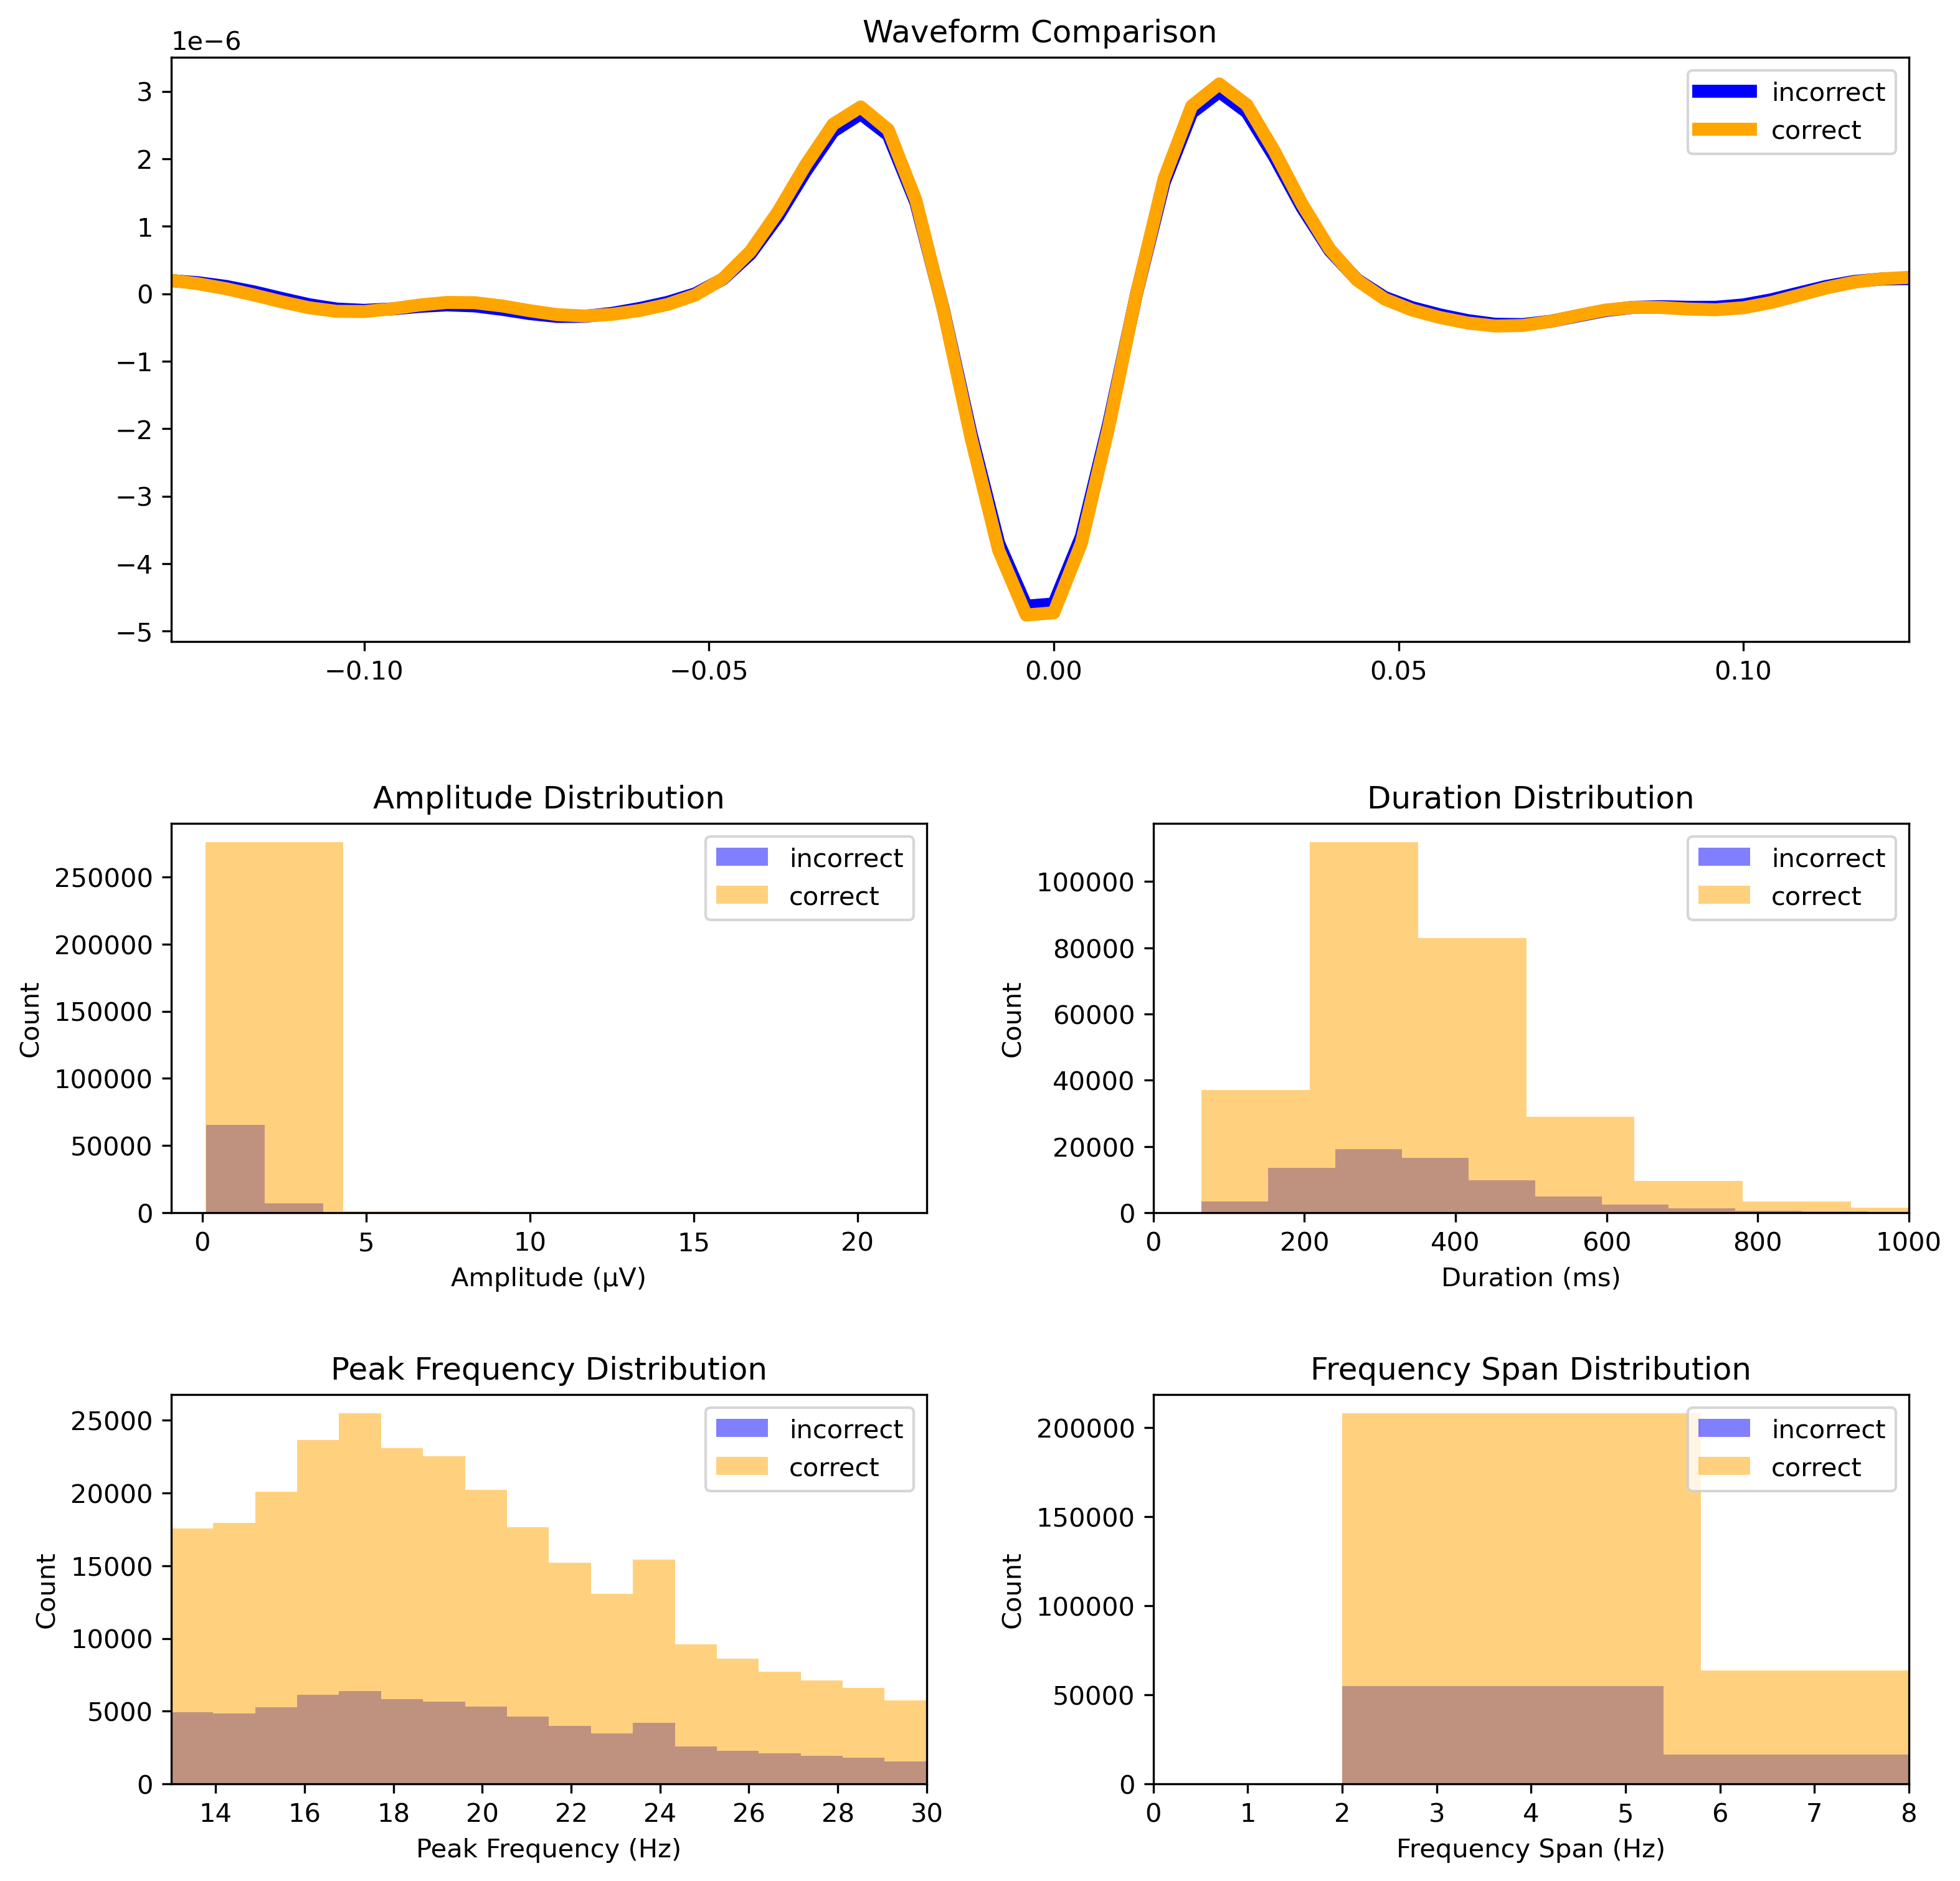

In [37]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Prepare the figure with GridSpec layout
fig = plt.figure(figsize=(12, 12), dpi=300)
gs = gridspec.GridSpec(3, 2, height_ratios=[1.5, 1, 1], hspace=0.4, wspace=0.3)

# Filter bursts by condition
bursts_correct = [burst for burst in bursts_all_results if burst['condition'][0] == 'correct']
bursts_incorrect = [burst for burst in bursts_all_results if burst['condition'][0] == 'incorrect']

# Waveform comparison plot (spans the first row)
ax0 = fig.add_subplot(gs[0, :])  # Span all columns
waveforms_incorrect = [burst["waveform"] for burst in bursts_incorrect]
waveforms_correct = [burst["waveform"] for burst in bursts_correct]
mean_waveform_incorrect = np.mean(np.concatenate(waveforms_incorrect, axis=0), axis=0)
mean_waveform_correct = np.mean(np.concatenate(waveforms_correct, axis=0), axis=0)
ax0.plot(waveform_times, mean_waveform_incorrect, lw=5, c="blue", label='incorrect')
ax0.plot(waveform_times, mean_waveform_correct, lw=5, c="orange", label='correct')
ax0.set_title("Waveform Comparison")
ax0.set_xlim(waveform_times[0], waveform_times[-1])
ax0.legend()

# Amplitude distribution (top left of second row)
ax1 = fig.add_subplot(gs[1, 0])
amplitudes_incorrect = np.concatenate([burst['peak_amp_base'] for burst in bursts_incorrect]) * 1e6  # Convert to µV
amplitudes_correct = np.concatenate([burst['peak_amp_base'] for burst in bursts_correct]) * 1e6  # Convert to µV
ax1.hist(amplitudes_incorrect, bins=5, alpha=0.5, color="blue", label="incorrect")
ax1.hist(amplitudes_correct, bins=5, alpha=0.5, color="orange", label="correct")
ax1.set_title("Amplitude Distribution")
ax1.set_xlabel("Amplitude (µV)")
# ax1.set_xlim(0, 4000)
ax1.set_ylabel("Count")
ax1.legend()

# Duration distribution (top right of second row)
ax2 = fig.add_subplot(gs[1, 1])
durations_incorrect = np.concatenate([burst['fwhm_time'] for burst in bursts_incorrect]) * 1e3  # Convert to ms
durations_correct = np.concatenate([burst['fwhm_time'] for burst in bursts_correct]) * 1e3  # Convert to ms
ax2.hist(durations_incorrect, bins=30, alpha=0.5, color="blue", label="incorrect")
ax2.hist(durations_correct, bins=30, alpha=0.5, color="orange", label="correct")
ax2.set_title("Duration Distribution")
ax2.set_xlabel("Duration (ms)")
ax2.set_xlim(0, 1000)
ax2.set_ylabel("Count")
ax2.legend()

# Peak frequency distribution (bottom left)
ax3 = fig.add_subplot(gs[2, 0])
peak_freq_incorrect = np.concatenate([burst['peak_freq'] for burst in bursts_incorrect])
peak_freq_correct = np.concatenate([burst['peak_freq'] for burst in bursts_correct])
ax3.hist(peak_freq_incorrect, bins=18, alpha=0.5, color="blue", label="incorrect")
ax3.hist(peak_freq_correct, bins=18, alpha=0.5, color="orange", label="correct")
ax3.set_title("Peak Frequency Distribution")
ax3.set_xlabel("Peak Frequency (Hz)")
ax3.set_ylabel("Count")
ax3.set_xlim(13, 30)
ax3.legend()

# Frequency span distribution (bottom right)
ax4 = fig.add_subplot(gs[2, 1])
freq_span_incorrect = np.concatenate([burst['fwhm_freq'] for burst in bursts_incorrect])
freq_span_correct = np.concatenate([burst['fwhm_freq'] for burst in bursts_correct])
ax4.hist(freq_span_incorrect, bins=10, alpha=0.5, color="blue", label="incorrect")
ax4.hist(freq_span_correct, bins=10, alpha=0.5, color="orange", label="correct")
ax4.set_title("Frequency Span Distribution")
ax4.set_xlim(0, 8)
ax4.set_xlabel("Frequency Span (Hz)")
ax4.set_ylabel("Count")
ax4.legend()

plt.tight_layout()
plt.show()

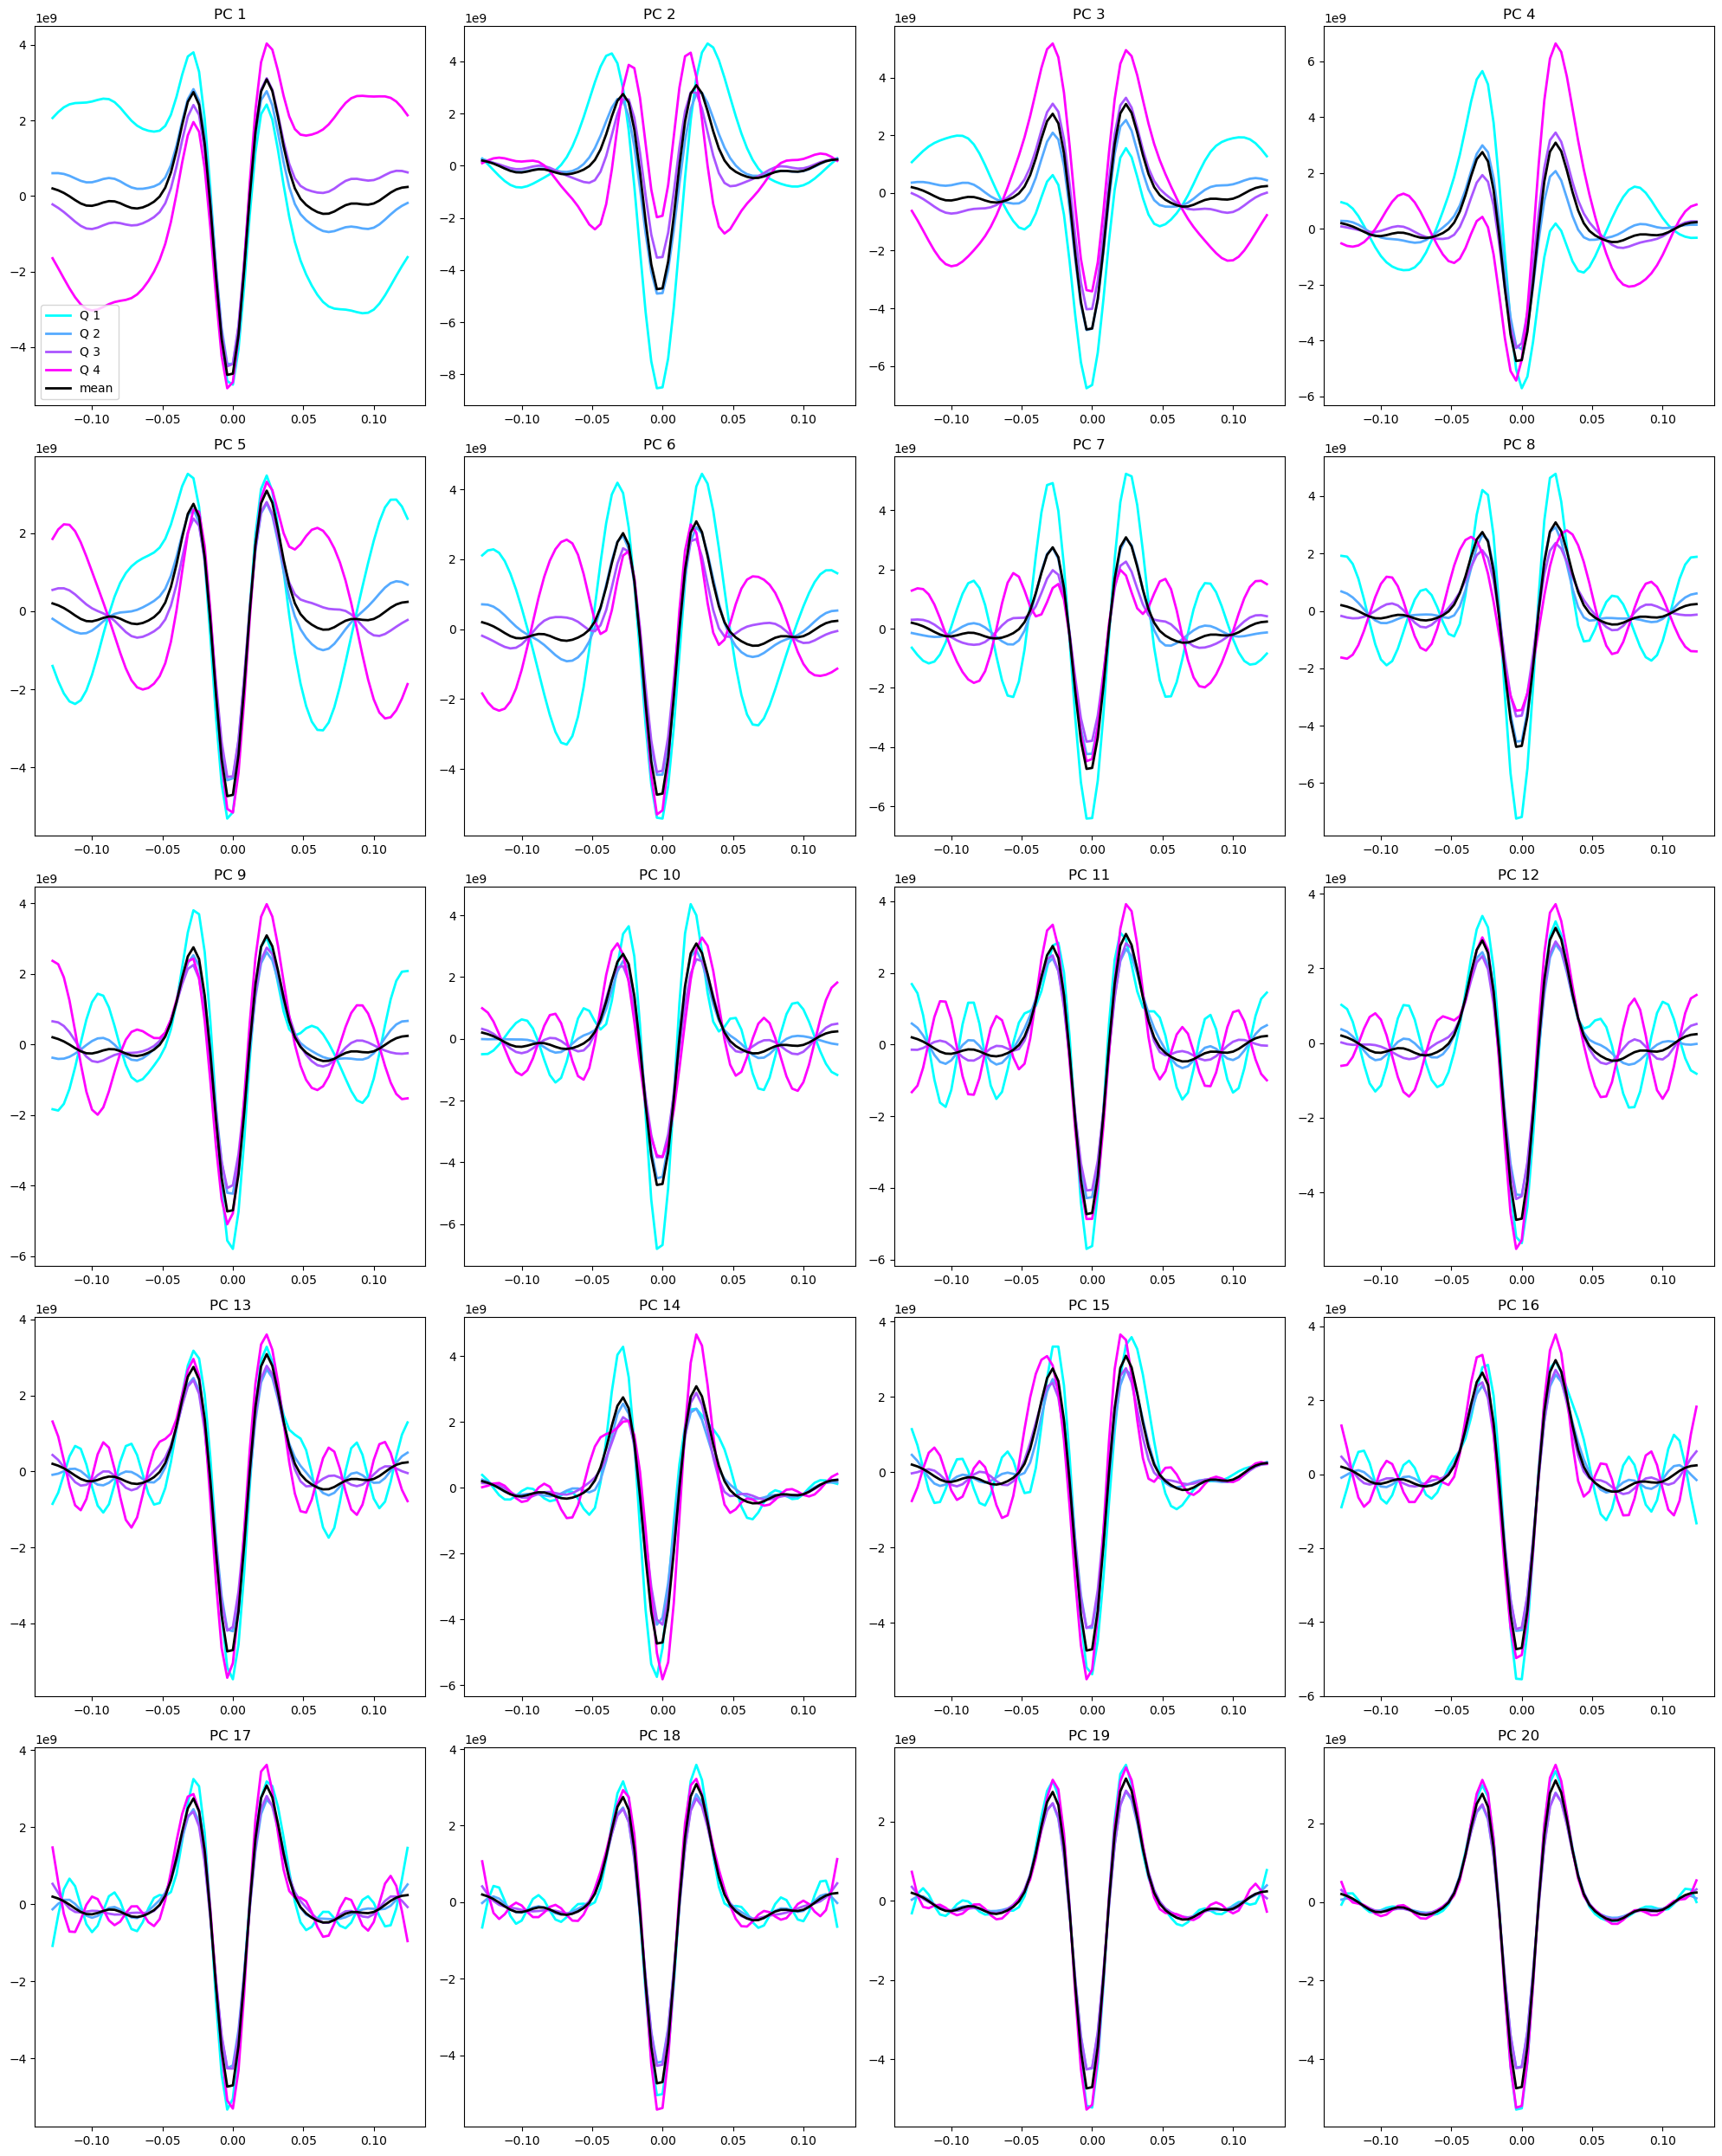

In [38]:

dict_output = {i: [] for i in bursts_all_results[0].keys() if not many_is_in(["waveform", "waveform_times"], i)}
waveforms = []

for b in bursts_all_results:
    [dict_output[k].append(b[k]) for k in dict_output.keys()]
    waveforms.append(b["waveform"])

for i in dict_output.keys():
    dict_output[i] = np.hstack(dict_output[i])
waveforms = np.vstack([i for i in waveforms if i.shape[0] > 0])  # all the bursts x time

amp_max = np.max(waveforms, axis=1)
amp_map = (amp_max >= np.percentile(amp_max, 0.5)) & (amp_max <= np.percentile(amp_max, 99.5))
# pca_subset = np.random.choice(np.arange(amp_max.shape[0])[amp_map], size=int(amp_max.shape[0]*0.5))

model = PCA(n_components=20)
scaler = RobustScaler().fit(waveforms)
burst_std = scaler.transform(waveforms)
model.fit(burst_std)
pc_scores = model.transform(burst_std)  # all the bursts x 20 components
pc_labels = ["PC_{}".format(i+1) for i in range(pc_scores.shape[1])]
pc_df = pd.DataFrame.from_dict({i: pc_scores[:, ix] for ix, i in enumerate(pc_labels)})
dict_output_df = pd.DataFrame.from_dict(dict_output)
features_scores = pd.concat([dict_output_df, pc_df], axis=1)

quartiles = np.linspace(0, 100, num=5)
quartiles = list(zip(quartiles[:-1], quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0, 1, num=len(quartiles)))
mean_waveform = np.mean(waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20, 25))
ax = ax.flatten()
for pc_ix, pc in enumerate(pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " "))  # set the nice title
    scores = features_scores[pc].values  # select the appropriate principal component from the dataframe
    q_maps = []
    for q_ix, (b, e) in enumerate(quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e))  # create a boolean map to select the waveforms
        q_mean = np.mean(waveforms[q_map], axis=0)
        ax[pc_ix].plot(waveform_times, q_mean/1e-15, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(waveform_times, mean_waveform/1e-15, lw=2, c="black", label="mean")
ax[0].legend(fontsize=10)

plt.tight_layout()
plt.show()

In [44]:
dict_output_df

trial  peak_freq  peak_amp_iter  peak_amp_base  peak_time  \
0           0       15.0   1.625995e-06   1.625995e-06     -0.804   
1           0       25.0   9.484033e-07   1.044481e-06      0.816   
2           0       24.0   7.462159e-07   7.921043e-07      0.500   
3           0       25.0   6.823332e-07   8.648442e-07      1.096   
4           0       23.0   6.280505e-07   6.287180e-07      0.032   
...       ...        ...            ...            ...        ...   
350039    159       18.0   9.943841e-07   9.943847e-07      1.100   
350040    159       20.0   9.665787e-07   9.665787e-07     -0.724   
350041    159       24.0   7.419396e-07   7.419397e-07      0.208   
350042    159       19.0   6.185575e-07   6.471629e-07     -0.260   
350043    159       25.0   4.691045e-07   4.976620e-07      0.704   

        peak_adjustment  fwhm_freq  fwhm_time  polarity  condition sensor  \
0                -0.016        4.0      0.568         0  incorrect     C3   
1                -0.008        4.0      0.304         0  incorrect     C3   
2                 0.008        2.0      0.296         1  incorrect     C3   
3                 0.004        2.0      0.208         0  incorrect     C3   
4                -0.012        4.0      0.456         1  incorrect     C3   
...                 ...        ...        ...       ...        ...    ...   
350039            0.000        4.0      0.472         0    correct     C4   
350040            0.008        4.0      0.400         1    correct     C4   
350041            0.008        8.0      0.400         0    correct     C4   
350042            0.008        4.0      0.296         1    correct     C4   
350043            0.008        4.0      0.256         0    correct     C4   

       epochs       subject  
0       trial  sub-AG05AS29  
1       trial  sub-AG05AS29  
2       trial  sub-AG05AS29  
3       trial  sub-AG05AS29  
4       trial  sub-AG05AS29  
...       ...           ...  
350039  trial  sub-XX04AS28  
350040  trial  sub-XX04AS28  
350041  trial  sub-XX04AS28  
350042  trial  sub-XX04AS28  
350043  trial  sub-XX04AS28  

[350044 rows x 13 columns]

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_48539/244733611.py:41: RuntimeWarning: Mean of empty slice
  mean_scores_over_trials = np.nanmean(trial_mean_scores, axis=0)  # Shape: bins x PCs


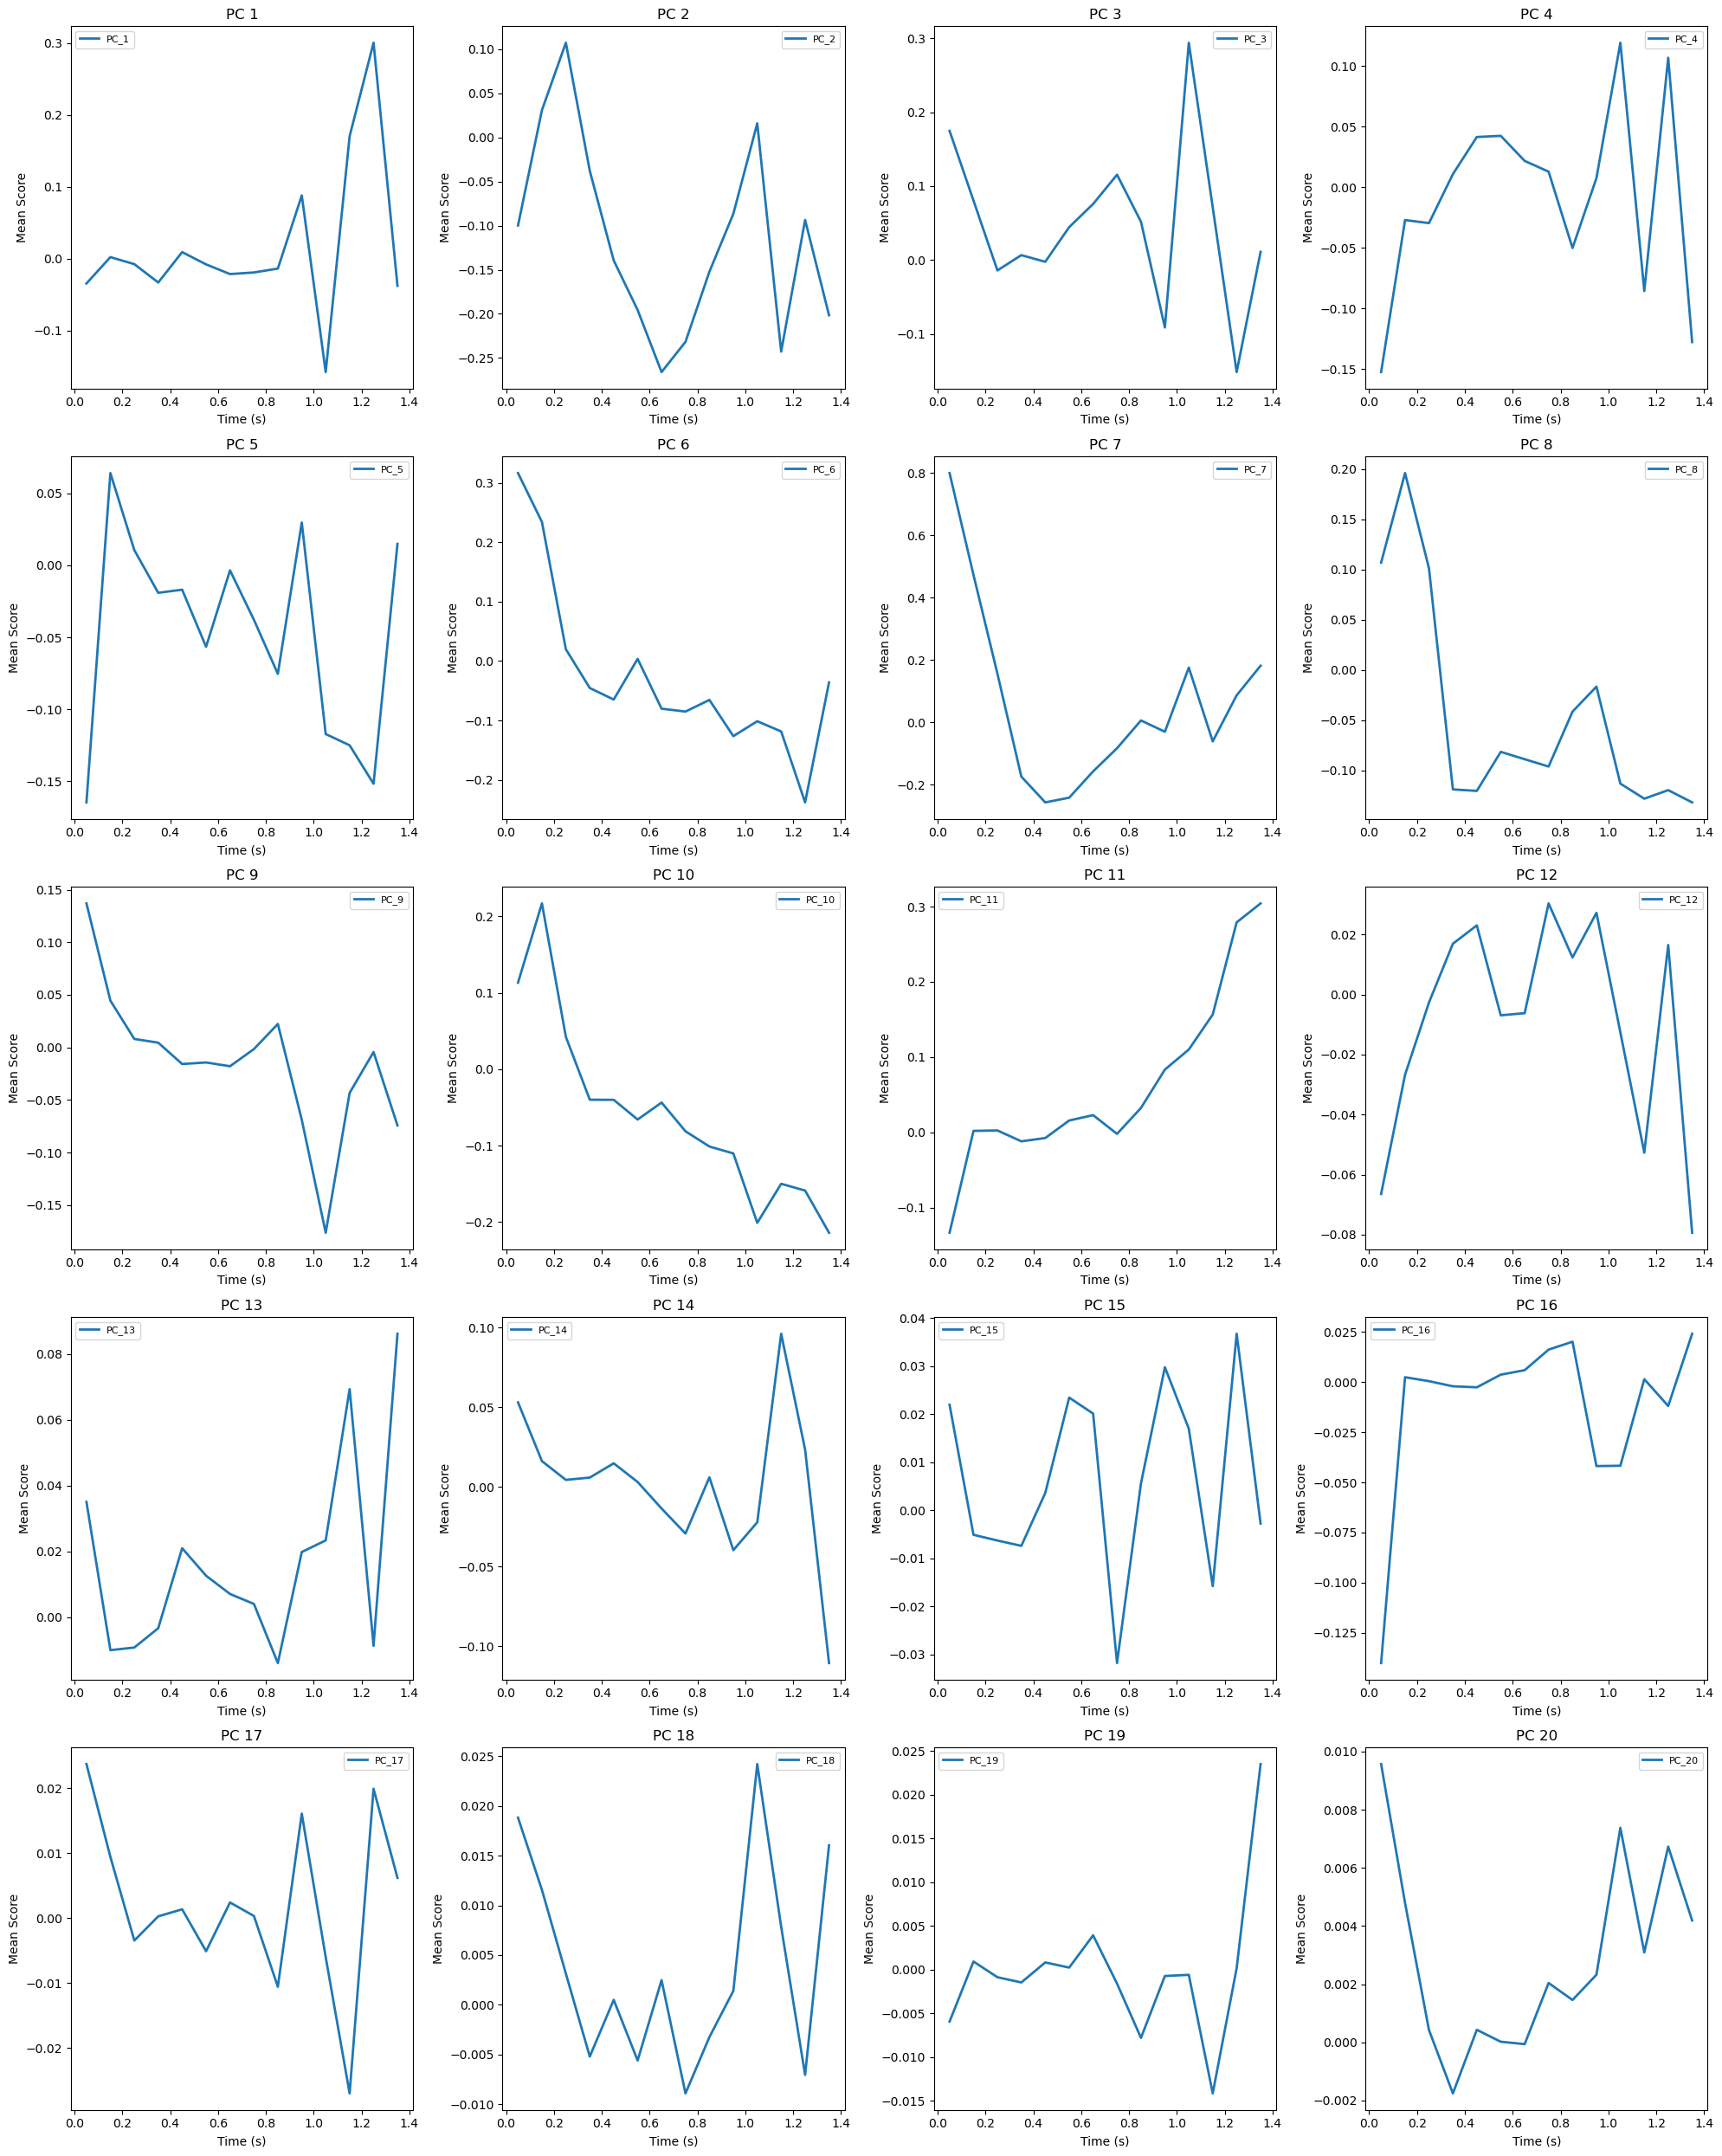

In [45]:
# Initialize storage for all trial results
trial_mean_scores = []

for subject in dict_output_df['subject'].unique():
    
    # Define the time range of interest and bin size
    time_start, time_end = -1.0, 1.5
    time_bins = np.arange(time_start, time_end, 0.1)  # Adjust bin size as needed (e.g., 0.1 seconds)

    # Assuming `dict_output_df` contains a "fwhm_time" column and a "trial" column
    time_column = dict_output_df["fwhm_time"]  # Adjust based on the actual name of the time column
    trial_column = dict_output_df["trial"]    # Column that identifies trials

    # Loop over unique trials
    for trial in trial_column.unique():
        # Filter data for the current trial
        trial_mask = trial_column == trial
        trial_times = time_column[trial_mask]
        trial_pc_scores = pc_scores[trial_mask, :]
        
        # Initialize storage for the current trial
        mean_scores_per_bin = []
        bin_centers = []

        # Compute mean PC scores for each bin in the trial
        for i in range(len(time_bins) - 1):
            bin_start, bin_end = time_bins[i], time_bins[i + 1]
            bin_mask = (trial_times >= bin_start) & (trial_times < bin_end)
            if np.any(bin_mask):  # Ensure there are data points in the bin
                mean_scores_per_bin.append(trial_pc_scores[bin_mask].mean(axis=0))
            else:
                mean_scores_per_bin.append(np.full(pc_scores.shape[1], np.nan))  # Handle empty bins
            bin_centers.append((bin_start + bin_end) / 2)

        trial_mean_scores.append(mean_scores_per_bin)

# Convert results to a NumPy array (shape: trials x bins x PCs)
trial_mean_scores = np.array(trial_mean_scores)

# Average over trials (ignoring NaNs)
mean_scores_over_trials = np.nanmean(trial_mean_scores, axis=0)  # Shape: bins x PCs

# Plot averaged PC scores over time
f, ax = plt.subplots(5, 4, figsize=(20, 25))  # Create subplots for 20 PCs
ax = ax.flatten()

for pc_ix, pc in enumerate(pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " "))  # Set PC title
    ax[pc_ix].plot(bin_centers, mean_scores_over_trials[:, pc_ix], lw=2, label=f"{pc}")  # Line plot of mean scores
    ax[pc_ix].set_xlabel("Time (s)")
    ax[pc_ix].set_ylabel("Mean Score")
    ax[pc_ix].legend(fontsize=8)

plt.tight_layout()
plt.show()


In [55]:
trial_mean_scores.shape

(40145, 24, 20)

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd

def calculate_burst_rates_by_pc_quartiles(df_burst, condition, sensors, epoch, pc_column, time_bin=0.05, time_buffer=0.125):
    """
    Calculate and baseline correct burst rates from burst peak times within each quartile of a specified PC score.
    
    Parameters:
    df_burst (DataFrame): DataFrame containing burst information with columns ['condition', 'sensor', 'epochs', 'subject', 'peak_time', pc_column].
    condition (str): Condition identifier ('short' or 'long').
    sensors (list): List of sensors to include in the analysis.
    epoch (str): Epoch identifier ('stim' or 'resp').
    pc_column (str): Column name for the PC score (e.g., 'PC_1').
    time_bin (float): Time bin size in seconds (default is 0.05).
    time_buffer (float): Time buffer around the epoch in seconds (default is 0.125).

    Returns:
    dict: A dictionary where keys are quartiles (1, 2, 3, 4) and values are lists of arrays containing smoothed and baseline-corrected burst rates for each subject in that quartile.
    """
    
    # Define the time range including buffer around the epoch
    time_range = np.arange(-1 - time_buffer, 2 + time_buffer, time_bin)
    
    # Find the indices corresponding to the baseline period (-0.5 to 0 seconds)
    baseline_start = np.argmin(np.abs(time_range - (-0.5)))
    baseline_end = np.argmin(np.abs(time_range - 0))
    
    # Filter the DataFrame for the specified condition, sensors, and epoch
    bursts = df_burst[(df_burst['condition'] == condition) & 
                      (df_burst['sensor'].isin(sensors)) & 
                      (df_burst['epochs'] == epoch)].copy()
    
    if bursts.empty:
        raise ValueError("No burst data found for the specified parameters.")
    
    # Determine quartiles for the specified PC score
    quartiles = pd.qcut(bursts[pc_column], 4, labels=False) + 1
    bursts['quartile'] = quartiles
    
    # Prepare a dictionary to store burst rates for each quartile
    burst_rates_by_quartile = {1: [], 2: [], 3: [], 4: []}

    subjects = bursts['subject'].unique()
    
    for quartile in range(1, 5):
        for subject in subjects:
            # Initialize burst rate array for the current subject
            subject_burst_rates = np.zeros(len(time_range))
            subject_df = bursts[(bursts['subject'] == subject) & (bursts['quartile'] == quartile)]

            for i, t in enumerate(time_range):
                subject_burst_rates[i] = len(subject_df[(subject_df['peak_time'] >= t) & 
                                                        (subject_df['peak_time'] < t + time_bin)]) / time_bin
            
            # Apply Gaussian smoothing to the burst rates
            subject_burst_rates_smoothed = gaussian_filter1d(subject_burst_rates, sigma=1)
            
            # Perform baseline correction
            baseline_mean = np.mean(subject_burst_rates_smoothed[baseline_start:baseline_end])
            if baseline_mean != 0:
                subject_burst_rates_smoothed = ((subject_burst_rates_smoothed - baseline_mean) / baseline_mean) * 100
            
            burst_rates_by_quartile[quartile].append(subject_burst_rates_smoothed)

    return burst_rates_by_quartile

In [63]:
features_scores.columns

Index(['trial', 'peak_freq', 'peak_amp_iter', 'peak_amp_base', 'peak_time',
       'peak_adjustment', 'fwhm_freq', 'fwhm_time', 'polarity', 'condition',
       'sensor', 'epochs', 'subject', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5',
       'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13',
       'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20'],
      dtype='object')

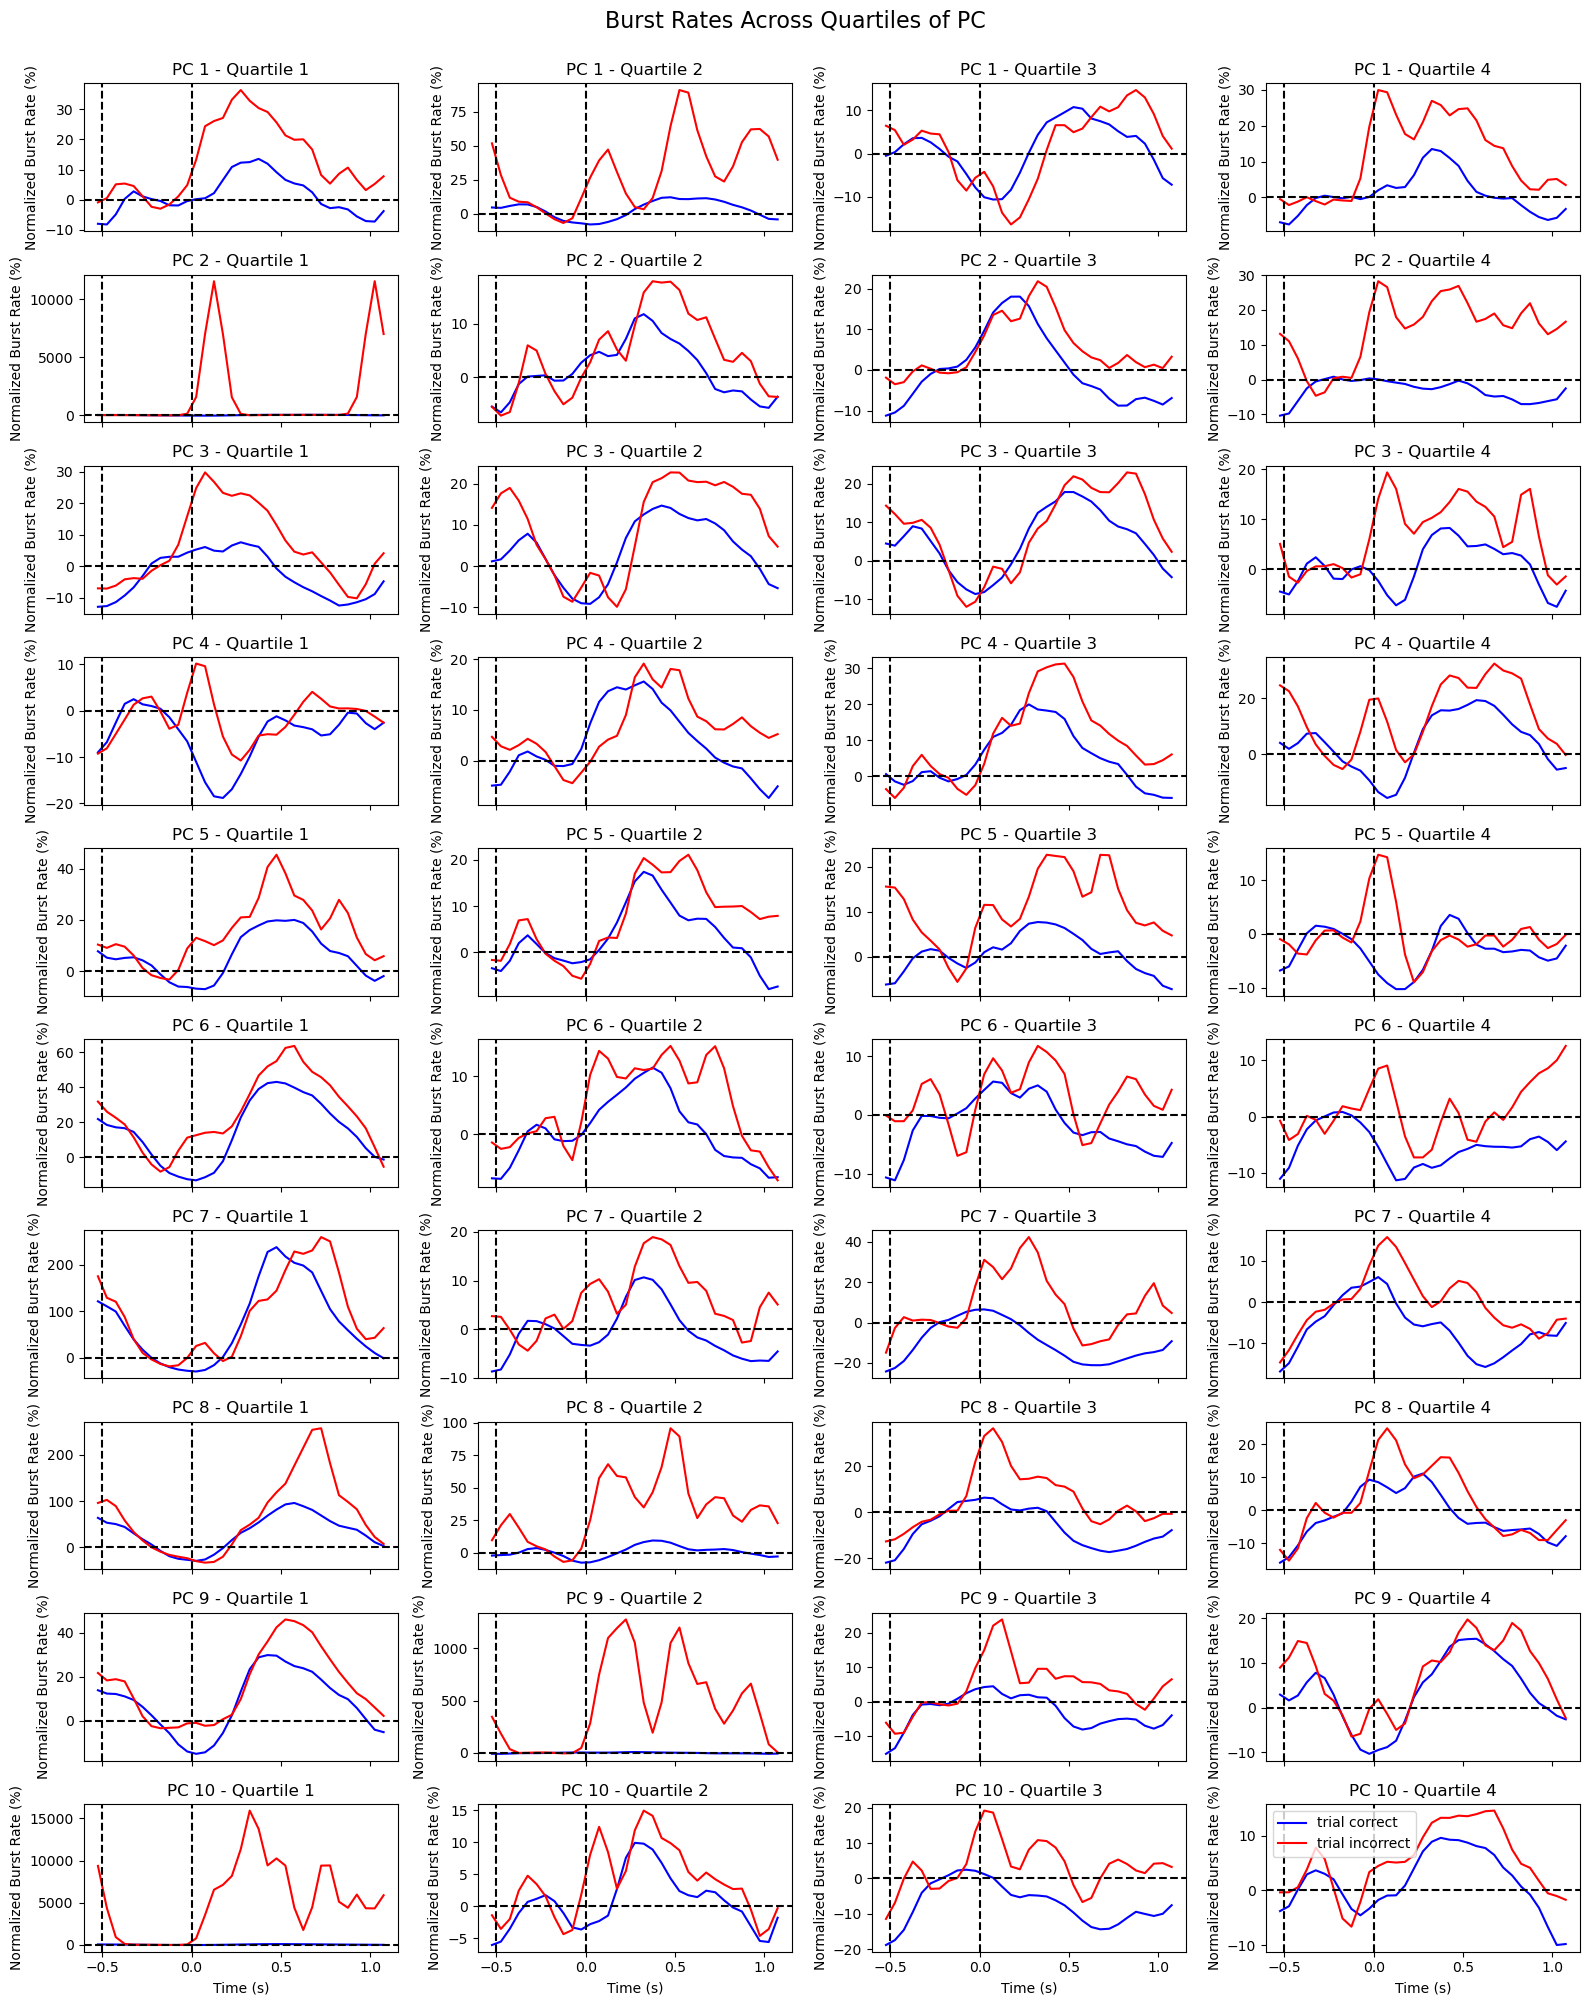

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_test
from scipy.stats import f_oneway

# Parameters
num_pcs = 10

# Create a single figure with subplots
fig, axes = plt.subplots(num_pcs, 4, figsize=(16, 20), sharex='col')

time_range = np.arange(-1 - 0.125, 2 + 0.125, 0.05)
selected_time_points = time_range[12:45]

# Iterate over each PC
for pc in range(1, num_pcs + 1):
    
    # Calculate burst rates by quartiles for the current PC for each condition
    burst_rates_trial_correct = calculate_burst_rates_by_pc_quartiles(
        features_scores,
        condition='correct',
        sensors=sensors,  # Replace with relevant sensors
        epoch='trial',  # Replace with relevant epoch
        pc_column=f'PC_{pc}'
    )

    burst_rates_trial_incorrect = calculate_burst_rates_by_pc_quartiles(
        features_scores,
        condition='incorrect',
        sensors=sensors,  # Replace with relevant sensors
        epoch='trial',  # Replace with relevant epoch
        pc_column=f'PC_{pc}'
    )
    
    
    # Iterate over each quartile
    for quartile, ax in zip(range(1, 5), axes[pc - 1]):
        # Plot burst rates for short stim condition
        mean_burst_rate_trial_correct = np.mean(burst_rates_trial_correct[quartile], axis=0)
        ax.plot(time_range[12:45], mean_burst_rate_trial_correct[12:45], label='trial correct', color='blue')

        # Plot burst rates for long stim condition
        mean_burst_rate_trial_incorrect = np.mean(burst_rates_trial_incorrect[quartile], axis=0)
        ax.plot(time_range[12:45], mean_burst_rate_trial_incorrect[12:45], label='trial incorrect', color='red')
        
        ax.axvline(x=0, color='k', linestyle='--')
        ax.axvline(x=-0.5, color='k', linestyle='--')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylabel('Normalized Burst Rate (%)')
        ax.set_title(f'PC {pc} - Quartile {quartile}')

# Set x-axis label for the last row of subplots
for ax in axes[-1]:
    ax.set_xlabel('Time (s)')


# Add a title
fig.suptitle('Burst Rates Across Quartiles of PC', fontsize=16, y=1)

# Adjust layout
plt.tight_layout()
plt.show()

In [52]:
# Count bursts per condition/subject/quartile
counts = (
    features_scores.groupby(["subject","condition","sensor","epochs"]).size().reset_index(name="n_bursts")
)
print(counts.head())
print(counts.groupby("condition")["n_bursts"].describe())

        subject  condition sensor epochs  n_bursts
0  sub-AG05AS29    correct     C3  trial       959
1  sub-AG05AS29    correct     C4  trial       955
2  sub-AG05AS29  incorrect     C3  trial        70
3  sub-AG05AS29  incorrect     C4  trial        58
4  sub-AH17AR05    correct     C3  trial       427
           count        mean         std    min    25%    50%     75%     max
condition                                                                    
correct    310.0  894.209677  194.802841  284.0  786.5  926.0  1026.5  1263.0
incorrect  310.0  234.964516  115.554728   43.0  144.5  227.0   302.5   623.0


In [72]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def calculate_burst_rates_by_pc_quartiles_dict(
    df_burst,                      # DataFrame with ['subject','sensor','condition','epochs','peak_time', 'PC_1', ...]
    epoch,                         # e.g. 'trial'
    condition,                     # 'correct' or 'incorrect'
    sensors,                       # list, e.g. ['C3','C4']
    pc_column,                     # e.g. 'PC_1'
    time_bin=0.05,
    time_buffer=0.125,
    baseline_window=(-0.3, 0.0),   # seconds
    smooth_sigma_s=0.05,           # seconds; set 0 to disable smoothing
    per_subject_quartiles=True,    # True: quartiles computed within each subject
    baseline_mode="percent"        # 'percent', 'zscore', or 'none'
):
    """
    Returns
    -------
    rates_dict : dict
        {(condition, subject, sensor, quartile): 1D array of burst-rate over time}
    time_range : 1D array of time bin centers
    """

    # --- filter rows you want
    bursts = df_burst[
        (df_burst['epochs'] == epoch) &
        (df_burst['condition'] == condition) &
        (df_burst['sensor'].isin(sensors))
    ].copy()
    if bursts.empty:
        return {}, np.array([])

    # --- time axis & edges
    time_range = np.arange(-1.0 - time_buffer, 2.0 + time_buffer, time_bin)
    edges = np.concatenate([time_range, [time_range[-1] + time_bin]])

    # baseline indices
    b0, b1 = baseline_window
    b_idx0 = np.argmin(np.abs(time_range - b0))
    b_idx1 = np.argmin(np.abs(time_range - b1))
    if b_idx1 <= b_idx0:
        raise ValueError("baseline_window must have start < end")

    # smoothing sigma in bins
    sigma_bins = (smooth_sigma_s / time_bin) if smooth_sigma_s and smooth_sigma_s > 0 else 0.0

    # --- assign quartiles
    if per_subject_quartiles:
        bursts['quartile'] = (
            bursts.groupby('subject', group_keys=False)[pc_column]
                  .apply(lambda s: pd.qcut(s, 4, labels=False, duplicates='drop'))
        )
    else:
        bursts['quartile'] = pd.qcut(bursts[pc_column], 4, labels=False, duplicates='drop')

    bursts = bursts.dropna(subset=['quartile']).copy()
    bursts['quartile'] = bursts['quartile'].astype(int) + 1  # 1..4

    rates_dict = {}

    # --- loop subjects × sensors × quartiles (like your template)
    for subject in bursts['subject'].unique():
        subj_df = bursts[bursts['subject'] == subject]
        for sensor in sensors:
            sen_df = subj_df[subj_df['sensor'] == sensor]
            if sen_df.empty:
                continue
            for q in (1, 2, 3, 4):
                df_q = sen_df[sen_df['quartile'] == q]
                # bin peak times -> counts
                if df_q.empty:
                    counts = np.zeros_like(time_range, dtype=float)
                else:
                    counts, _ = np.histogram(df_q['peak_time'].values, bins=edges)
                    counts = counts.astype(float)

                # convert to rate (Hz) and smooth
                rate = counts / time_bin
                if sigma_bins > 0:
                    rate = gaussian_filter1d(rate, sigma=sigma_bins, mode='nearest')

                # baseline normalization
                if baseline_mode == "percent":
                    base = rate[b_idx0:b_idx1].mean()
                    base = max(base, 1e-3)  # floor to prevent explosions
                    value = (rate - base) / base * 100.0
                elif baseline_mode == "zscore":
                    bw = rate[b_idx0:b_idx1]
                    mu, sd = np.nanmean(bw), np.nanstd(bw)
                    sd = max(sd, 1e-6)
                    value = (rate - mu) / sd
                else:
                    value = rate

                rates_dict[(condition, subject, sensor, q)] = value

    return rates_dict, time_range

In [73]:
# build for both conditions & PCs you care about
rates_corr_pc1, t = calculate_burst_rates_by_pc_quartiles_dict(
    features_scores, epoch="trial", condition="correct",
    sensors=["C3","C4"], pc_column="PC_1",
    per_subject_quartiles=True, baseline_mode="zscore"
)
rates_inc_pc1, _ = calculate_burst_rates_by_pc_quartiles_dict(
    features_scores, epoch="trial", condition="incorrect",
    sensors=["C3","C4"], pc_column="PC_1",
    per_subject_quartiles=True, baseline_mode="zscore"
)

# average across subjects for, say, C3, quartile 4:
def stack(rates_dict, sensor, quartile):
    arrs = [v for (cond, subj, sen, q), v in rates_dict.items()
            if sen == sensor and q == quartile]
    return np.vstack(arrs) if arrs else np.empty((0, len(t)))

Xc = stack(rates_corr_pc1, sensor="C3", quartile=4)
Xi = stack(rates_inc_pc1, sensor="C3", quartile=4)

mean_c = Xc.mean(axis=0); sem_c = Xc.std(axis=0, ddof=1) / np.sqrt(max(1, Xc.shape[0]))
mean_i = Xi.mean(axis=0); sem_i = Xi.std(axis=0, ddof=1) / np.sqrt(max(1, Xi.shape[0]))

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pc_quartiles_conditions_sensors(
    df_long,
    pcs,
    sensors,
    epoch="trial",
    quartiles=(1,2,3,4),
    slice_window=(-0.5, 1.0),
    colors={
        ("correct","C3"): "tab:blue",
        ("correct","C4"): "dodgerblue",
        ("incorrect","C3"): "tab:red",
        ("incorrect","C4"): "tomato",
    },
    baseline_window=(-0.3,0.0)
):
    """
    Grid: rows = PCs, cols = quartiles.
    Each panel shows mean ± SEM for condition×sensor curves.
    """

    # filter dataframe
    df = df_long.copy()
    df = df[df["epoch"] == epoch]
    df = df[df["pc"].isin(pcs)]
    df = df[df["quartile"].isin(quartiles)]
    df = df[df["sensor"].isin(sensors)]

    times = np.sort(df["time"].unique())
    if slice_window is not None:
        tmask = (times >= slice_window[0]) & (times <= slice_window[1])
    else:
        tmask = slice(None)
    times_plot = times[tmask]

    fig, axes = plt.subplots(len(pcs), len(quartiles),
                             figsize=(len(quartiles)*3.2, len(pcs)*2.0),
                             sharex=True, sharey=False)

    if len(pcs) == 1: axes = np.array([axes])
    if len(quartiles) == 1: axes = axes.reshape(len(pcs), 1)

    for r, pc in enumerate(pcs):
        for c, q in enumerate(quartiles):
            ax = axes[r, c]
            panel = df[(df["pc"]==pc) & (df["quartile"]==q)]

            for cond in ["correct","incorrect"]:
                for sen in sensors:
                    g = panel[(panel["condition"]==cond) & (panel["sensor"]==sen)]
                    if g.empty: 
                        continue

                    # subject-level wide matrix
                    M = (
                        g.pivot_table(index="subject", columns="time", values="value")
                         .reindex(columns=times)
                    )
                    if M.shape[0] == 0: 
                        continue

                    mean = M.mean(axis=0).values[tmask]
                    sem  = M.std(axis=0, ddof=1).values[tmask] / np.sqrt(M.shape[0])
                    color = colors.get((cond,sen), None)
                    label = f"{cond}-{sen}"

                    ax.plot(times_plot, mean, lw=2, label=label, color=color)

            # reference lines
            ax.axvline(0, color="k", ls="--", lw=1)
            ax.axhline(0, color="k", ls="--", lw=1)
            ax.axvspan(baseline_window[0], baseline_window[1], color="k", alpha=0.05)

            if r == 0:
                ax.set_title(f"Quartile {q}")
            if c == 0:
                ax.set_ylabel(f"{pc}")

    # shared labels
    for ax in axes[-1,:]:
        ax.set_xlabel("Time (s)")

    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right", frameon=False)

    fig.suptitle("Burst Rates Across Quartiles of PC (by condition × sensor)", y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()

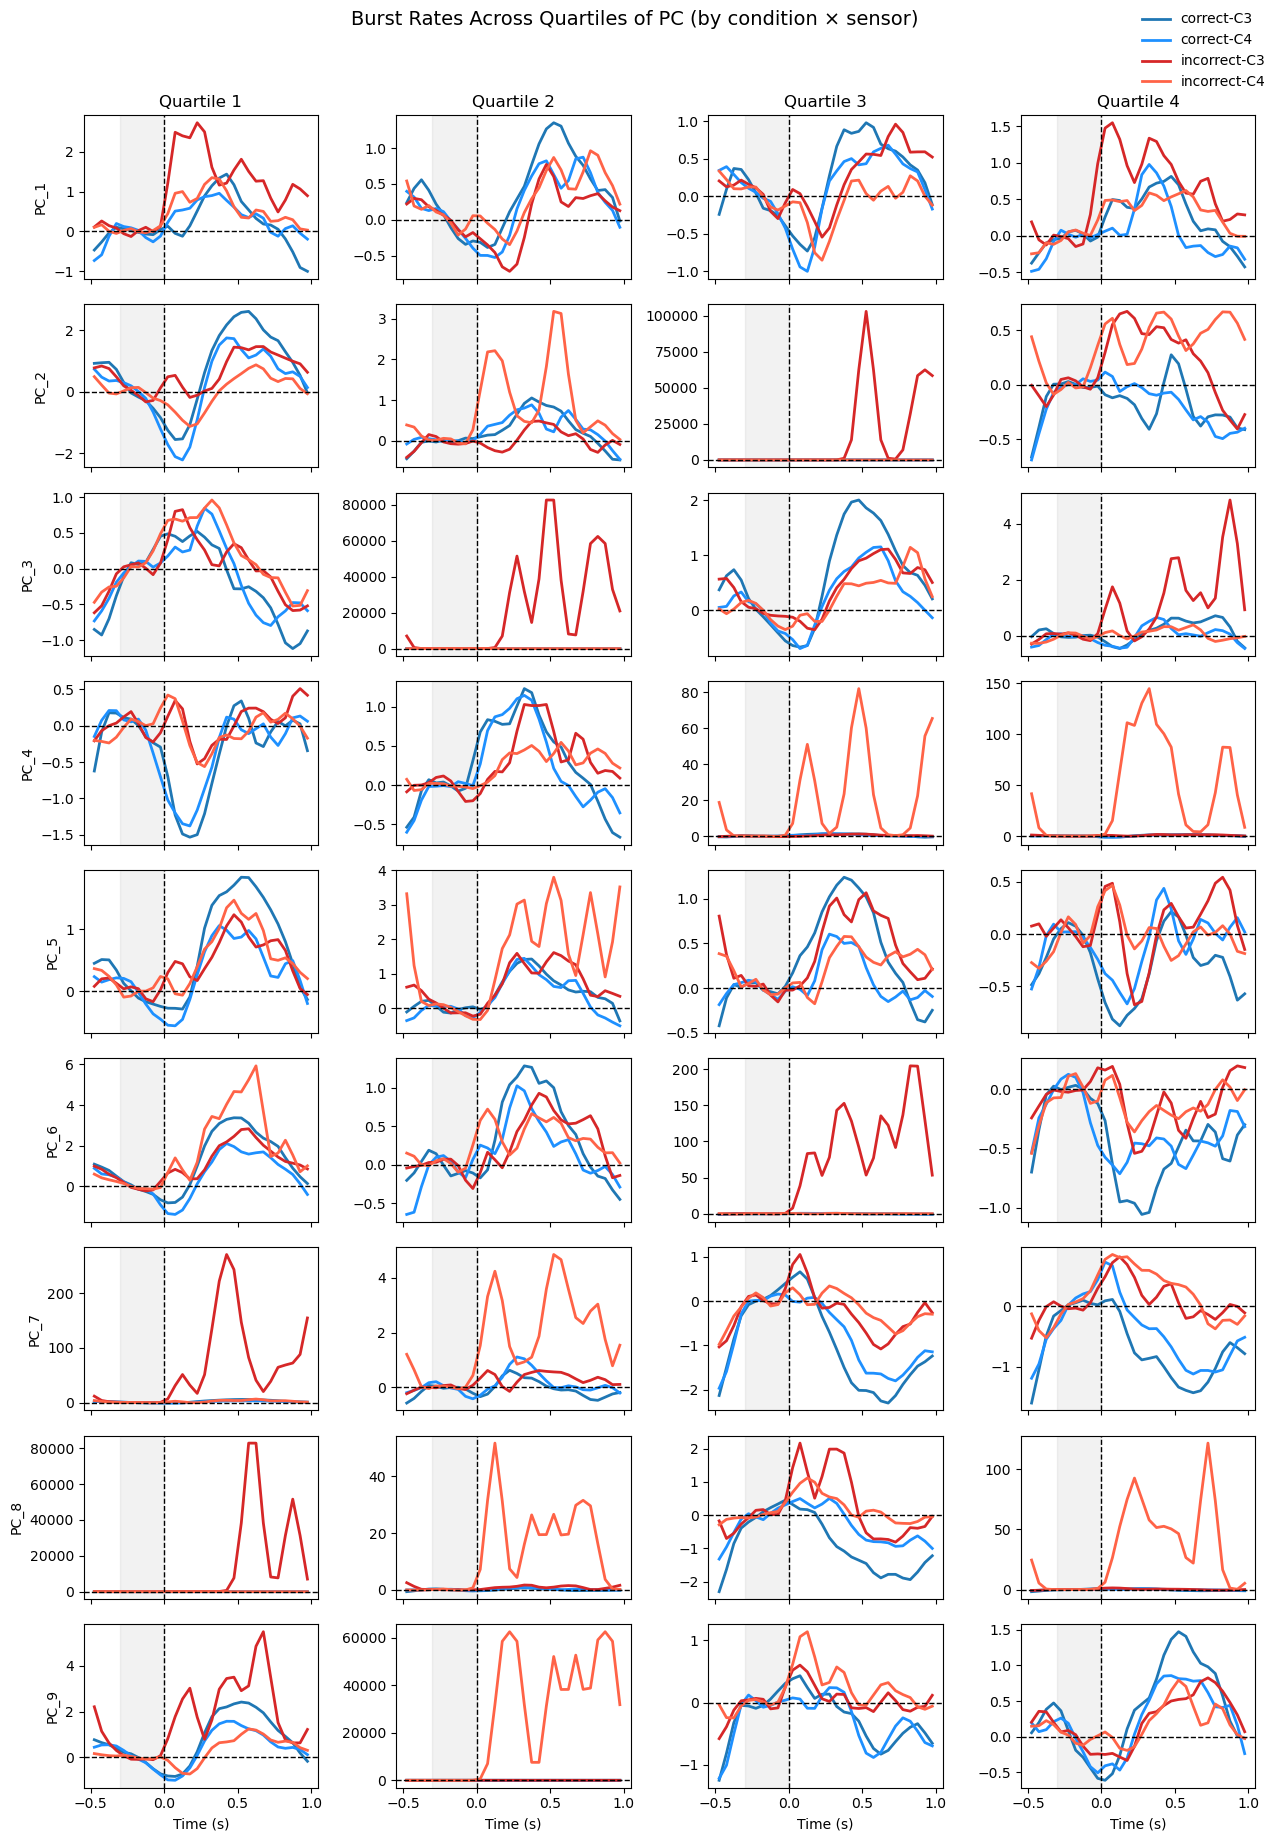

In [82]:
pcs = [f"PC_{i}" for i in range(1, 10)]   # first 5 PCs
sensors = ["C3","C4"]

plot_pc_quartiles_conditions_sensors(
    df_long,
    pcs=pcs,
    sensors=sensors,
    epoch="trial",
    quartiles=(1,2,3,4),
    slice_window=(-0.5, 1.0)
)

In [83]:
df_long

subject sensor  condition  epoch  quartile     pc   time  \
0        sub-AG05AS29     C3    correct  trial         1   PC_1 -1.125   
1        sub-AG05AS29     C3    correct  trial         1   PC_1 -1.075   
2        sub-AG05AS29     C3    correct  trial         1   PC_1 -1.025   
3        sub-AG05AS29     C3    correct  trial         1   PC_1 -0.975   
4        sub-AG05AS29     C3    correct  trial         1   PC_1 -0.925   
...               ...    ...        ...    ...       ...    ...    ...   
1636795  sub-XX04AS28     C4  incorrect  trial         4  PC_10  1.925   
1636796  sub-XX04AS28     C4  incorrect  trial         4  PC_10  1.975   
1636797  sub-XX04AS28     C4  incorrect  trial         4  PC_10  2.025   
1636798  sub-XX04AS28     C4  incorrect  trial         4  PC_10  2.075   
1636799  sub-XX04AS28     C4  incorrect  trial         4  PC_10  2.125   

             value  n_in_bin    norm  
0       -12.004151         0  zscore  
1       -12.002242         0  zscore  
2       -11.939036         0  zscore  
3       -11.169025         0  zscore  
4        -7.718074         0  zscore  
...            ...       ...     ...  
1636795  -4.768619         0  zscore  
1636796  -4.768619         0  zscore  
1636797  -4.768619         0  zscore  
1636798  -4.768619         0  zscore  
1636799  -4.768619         0  zscore  

[1636800 rows x 10 columns]